# Intraday Strategy Using GARCH Model

1. Using simulated daily data and intraday 5-min data.
2. Load Daily and 5-minute data.
3. Define function to fit GARCH model on the daily data and predict 1-day ahead volatility in a rolling window.
4. Calculate prediction premium and form a daily signal from it.
5. Merge with intraday data and calculate intraday indicators to form the intraday signal.
6. Generate the position entry and hold until the end of the day.
7. Calculate final strategy returns.

## Loading Simulated Daily and Simulated 5-min data. 

Loading both of the datasets, setting indexes and calculating the log returns. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch import arch_model
import pandas_ta

In [2]:
df_intraday = pd.read_csv('simulated_5min_data.csv')
df_day = pd.read_csv('simulated_daily_data.csv')

In [3]:
df_day

,Date,Open,High,Low,Close,Adj Close,Volume,Unnamed: 7
0,9/17/2014,116.466003,117.043503,113.105499,114.333504,114.333504,2.105680e+07,NaN
1,9/18/2014,114.214996,114.214996,103.276001,106.110001,106.110001,3.448320e+07,NaN
2,9/19/2014,106.025749,106.958748,96.133003,98.698998,98.698998,3.791970e+07,NaN
3,9/20/2014,98.668251,105.823998,97.470749,102.225998,102.225998,3.686360e+07,NaN
4,9/21/2014,102.021248,103.106499,98.295250,99.705254,99.705254,2.658010e+07,NaN
...,...,...,...,...,...,...,...,...
3284,9/14/2023,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,NaN
3285,9/15/2023,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,NaN
3286,9/16/2023,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,NaN
3287,9/17/2023,6641.981934,6654.499512,6611.268555,6633.546875,6633.546875,6.774211e+09,NaN


In [4]:
df_intraday

,datetime,open,low,high,close,volume,Unnamed: 6
0,9/29/2021 20:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN
1,9/29/2021 20:05,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN
2,9/29/2021 20:10,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN
3,9/29/2021 20:15,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN
4,9/29/2021 20:20,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN
...,...,...,...,...,...,...,...
177872,9/20/2023 10:40,6792.1025,6783.6000,6796.2500,6790.1375,41,NaN
177873,9/20/2023 10:45,6790.5575,6779.1000,6795.7500,6781.9175,42,NaN
177874,9/20/2023 10:50,6781.5475,6779.3750,6790.2500,6783.9050,44,NaN
177875,9/20/2023 10:55,6783.9025,6779.9000,6793.2500,6782.0900,95,NaN


In [5]:
df_day['Date'] = pd.to_datetime(df_day['Date'])

In [6]:
df_day = df_day.set_index('Date')

In [7]:
df_day

,Open,High,Low,Close,Adj Close,Volume,Unnamed: 7
Date,,,,,,,
2014-09-17,116.466003,117.043503,113.105499,114.333504,114.333504,2.105680e+07,NaN
2014-09-18,114.214996,114.214996,103.276001,106.110001,106.110001,3.448320e+07,NaN
2014-09-19,106.025749,106.958748,96.133003,98.698998,98.698998,3.791970e+07,NaN
2014-09-20,98.668251,105.823998,97.470749,102.225998,102.225998,3.686360e+07,NaN
2014-09-21,102.021248,103.106499,98.295250,99.705254,99.705254,2.658010e+07,NaN
...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,NaN
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,NaN
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,NaN


In [8]:
df_day.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Unnamed: 7'], dtype='object')

In [9]:
# doing the same for the 5 mins data
df_intraday['datetime'] = pd.to_datetime(df_intraday['datetime'])
df_intraday = df_intraday.set_index('datetime')
df_intraday

,open,low,high,close,volume,Unnamed: 6
datetime,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN
...,...,...,...,...,...,...
2023-09-20 10:40:00,6792.1025,6783.6000,6796.2500,6790.1375,41,NaN
2023-09-20 10:45:00,6790.5575,6779.1000,6795.7500,6781.9175,42,NaN
2023-09-20 10:50:00,6781.5475,6779.3750,6790.2500,6783.9050,44,NaN


In [10]:
#removing the unnamed column from the 5 mins data
df_intraday = df_intraday.drop('Unnamed: 6', axis=1)
df_intraday

,open,low,high,close,volume
datetime,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65
...,...,...,...,...,...
2023-09-20 10:40:00,6792.1025,6783.6000,6796.2500,6790.1375,41
2023-09-20 10:45:00,6790.5575,6779.1000,6795.7500,6781.9175,42
2023-09-20 10:50:00,6781.5475,6779.3750,6790.2500,6783.9050,44


## Now defining the function to fit the GARCH model and predict 1 day ahead volatility in a rolling window. 

We are first calculating the 6-month rolling variance and then we are creating a function in a 6-month rolling window to fit a garch model and predict the next day variance.

In [11]:
df_day['log return'] = np.log(df_day['Adj Close']).diff()
df_day

,Open,High,Low,Close,Adj Close,Volume,Unnamed: 7,log return
Date,,,,,,,,
2014-09-17,116.466003,117.043503,113.105499,114.333504,114.333504,2.105680e+07,NaN,NaN
2014-09-18,114.214996,114.214996,103.276001,106.110001,106.110001,3.448320e+07,NaN,-0.074643
2014-09-19,106.025749,106.958748,96.133003,98.698998,98.698998,3.791970e+07,NaN,-0.072402
2014-09-20,98.668251,105.823998,97.470749,102.225998,102.225998,3.686360e+07,NaN,0.035111
2014-09-21,102.021248,103.106499,98.295250,99.705254,99.705254,2.658010e+07,NaN,-0.024968
...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,NaN,0.011801
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,NaN,0.002597
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,NaN,-0.001520


In [12]:
df_day['variance'] = df_day['log return'].rolling(180).var()
df_day

,Open,High,Low,Close,Adj Close,Volume,Unnamed: 7,log return,variance
Date,,,,,,,,,
2014-09-17,116.466003,117.043503,113.105499,114.333504,114.333504,2.105680e+07,NaN,NaN,NaN
2014-09-18,114.214996,114.214996,103.276001,106.110001,106.110001,3.448320e+07,NaN,-0.074643,NaN
2014-09-19,106.025749,106.958748,96.133003,98.698998,98.698998,3.791970e+07,NaN,-0.072402,NaN
2014-09-20,98.668251,105.823998,97.470749,102.225998,102.225998,3.686360e+07,NaN,0.035111,NaN
2014-09-21,102.021248,103.106499,98.295250,99.705254,99.705254,2.658010e+07,NaN,-0.024968,NaN
...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,NaN,0.011801,0.000393
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,NaN,0.002597,0.000385
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,NaN,-0.001520,0.000384


<Axes: xlabel='Date'>

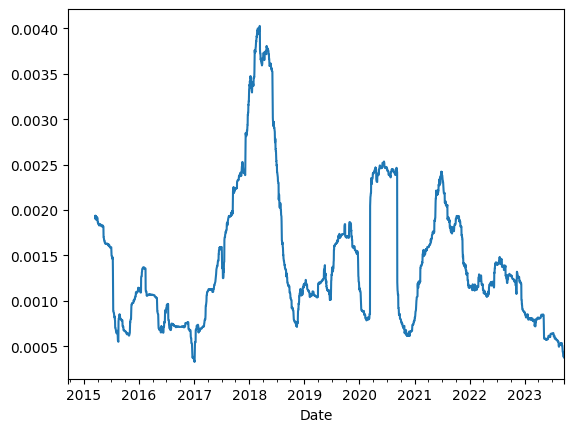

In [13]:
df_day['variance'].plot()

In [14]:
#Now defining a function from which we can predict the volatility using garch model. 
def pred_garch_volatility(x):
    best_model = arch_model(y=x, p=1, q=3).fit(update_freq=5, disp='off')
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1,0]

    print(x.index[-1])
    
    return variance_forecast

In [15]:
#Applying the function to the daily data
df_day['predictions'] = df_day['log return'].rolling(180).apply(lambda x: pred_garch_volatility(x))
df_day = df_day.dropna()
df_day

/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001921. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001894. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2015-03-16 00:00:00
2015-03-17 00:00:00
2015-03-18 00:00:00
2015-03-19 00:00:00
2015-03-20 00:00:00
2015-03-21 00:00:00
2015-03-22 00:00:00
2015-03-23 00:00:00
2015-03-24 00:00:00
2015-03-25 00:00:00
2015-03-26 00:00:00
2015-03-27 00:00:00
2015-03-28 00:00:00
2015-03-29 00:00:00
2015-03-30 00:00:00
2015-03-31 00:00:00
2015-04-01 00:00:00
2015-04-02 00:00:00
2015-04-03 00:00:00
2015-04-04 00:00:00
2015-04-05 00:00:00
2015-04-06 00:00:00
2015-04-07 00:00:00
2015-04-08 00:00:00
2015-04-09 00:00:00
2015-04-10 00:00:00
2015-04-11 00:00:00
2015-04-12 00:00:00
2015-04-13 00:00:00
2015-04-14 00:00:00
2015-04-15 00:00:00
2015-04-16 00:00:00
2015-04-17 00:00:00
2015-04-18 00:00:00
2015-04-19 00:00:00
2015-04-20 00:00:00
2015-04-21 00:00:00
2015-04-22 00:00:00
2015-04-23 00:00:00
2015-04-24 00:00:00
2015-04-25 00:00:00
2015-04-26 00:00:00
2015-04-27 00:00:00
2015-04-28 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001833. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001838. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2015-04-29 00:00:00
2015-04-30 00:00:00
2015-05-01 00:00:00
2015-05-02 00:00:00
2015-05-03 00:00:00
2015-05-04 00:00:00
2015-05-05 00:00:00
2015-05-06 00:00:00
2015-05-07 00:00:00
2015-05-08 00:00:00
2015-05-09 00:00:00
2015-05-10 00:00:00
2015-05-11 00:00:00
2015-05-12 00:00:00
2015-05-13 00:00:00
2015-05-14 00:00:00
2015-05-15 00:00:00
2015-05-16 00:00:00
2015-05-17 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001651. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001632. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2015-05-18 00:00:00
2015-05-19 00:00:00
2015-05-20 00:00:00
2015-05-21 00:00:00
2015-05-22 00:00:00
2015-05-23 00:00:00
2015-05-24 00:00:00
2015-05-25 00:00:00
2015-05-26 00:00:00
2015-05-27 00:00:00
2015-05-28 00:00:00
2015-05-29 00:00:00
2015-05-30 00:00:00
2015-05-31 00:00:00
2015-06-01 00:00:00
2015-06-02 00:00:00
2015-06-03 00:00:00
2015-06-04 00:00:00
2015-06-05 00:00:00
2015-06-06 00:00:00
2015-06-07 00:00:00
2015-06-08 00:00:00
2015-06-09 00:00:00
2015-06-10 00:00:00
2015-06-11 00:00:00
2015-06-12 00:00:00
2015-06-13 00:00:00
2015-06-14 00:00:00
2015-06-15 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001596. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001595. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2015-06-16 00:00:00
2015-06-17 00:00:00
2015-06-18 00:00:00
2015-06-19 00:00:00
2015-06-20 00:00:00
2015-06-21 00:00:00
2015-06-22 00:00:00
2015-06-23 00:00:00
2015-06-24 00:00:00
2015-06-25 00:00:00
2015-06-26 00:00:00
2015-06-27 00:00:00
2015-06-28 00:00:00
2015-06-29 00:00:00
2015-06-30 00:00:00
2015-07-01 00:00:00
2015-07-02 00:00:00
2015-07-03 00:00:00
2015-07-04 00:00:00
2015-07-05 00:00:00
2015-07-06 00:00:00
2015-07-07 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001471. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001455. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2015-07-08 00:00:00
2015-07-09 00:00:00
2015-07-10 00:00:00
2015-07-11 00:00:00
2015-07-12 00:00:00
2015-07-13 00:00:00
2015-07-14 00:00:00
2015-07-15 00:00:00
2015-07-16 00:00:00
2015-07-17 00:00:00
2015-07-18 00:00:00
2015-07-19 00:00:00
2015-07-20 00:00:00
2015-07-21 00:00:00
2015-07-22 00:00:00
2015-07-23 00:00:00
2015-07-24 00:00:00
2015-07-25 00:00:00
2015-07-26 00:00:00
2015-07-27 00:00:00
2015-07-28 00:00:00
2015-07-29 00:00:00
2015-07-30 00:00:00
2015-07-31 00:00:00
2015-08-01 00:00:00
2015-08-02 00:00:00
2015-08-03 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006548. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000655. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-p

2015-08-04 00:00:00
2015-08-05 00:00:00
2015-08-06 00:00:00
2015-08-07 00:00:00
2015-08-08 00:00:00
2015-08-09 00:00:00
2015-08-10 00:00:00
2015-08-11 00:00:00
2015-08-12 00:00:00
2015-08-13 00:00:00
2015-08-14 00:00:00
2015-08-15 00:00:00
2015-08-16 00:00:00
2015-08-17 00:00:00
2015-08-18 00:00:00
2015-08-19 00:00:00
2015-08-20 00:00:00
2015-08-21 00:00:00
2015-08-22 00:00:00
2015-08-23 00:00:00
2015-08-24 00:00:00
2015-08-25 00:00:00
2015-08-26 00:00:00
2015-08-27 00:00:00
2015-08-28 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008226. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008244. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2015-08-29 00:00:00
2015-08-30 00:00:00
2015-08-31 00:00:00
2015-09-01 00:00:00
2015-09-02 00:00:00
2015-09-03 00:00:00
2015-09-04 00:00:00
2015-09-05 00:00:00
2015-09-06 00:00:00
2015-09-07 00:00:00
2015-09-08 00:00:00
2015-09-09 00:00:00
2015-09-10 00:00:00
2015-09-11 00:00:00
2015-09-12 00:00:00
2015-09-13 00:00:00
2015-09-14 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000718. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007161. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-p

2015-09-15 00:00:00
2015-09-16 00:00:00
2015-09-17 00:00:00
2015-09-18 00:00:00
2015-09-19 00:00:00
2015-09-20 00:00:00
2015-09-21 00:00:00
2015-09-22 00:00:00
2015-09-23 00:00:00
2015-09-24 00:00:00
2015-09-25 00:00:00
2015-09-26 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000664. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006672. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-p

2015-09-27 00:00:00
2015-09-28 00:00:00
2015-09-29 00:00:00
2015-09-30 00:00:00
2015-10-01 00:00:00
2015-10-02 00:00:00
2015-10-03 00:00:00
2015-10-04 00:00:00
2015-10-05 00:00:00
2015-10-06 00:00:00
2015-10-07 00:00:00
2015-10-08 00:00:00
2015-10-09 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006374. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006342. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2015-10-10 00:00:00
2015-10-11 00:00:00
2015-10-12 00:00:00
2015-10-13 00:00:00
2015-10-14 00:00:00
2015-10-15 00:00:00
2015-10-16 00:00:00
2015-10-17 00:00:00
2015-10-18 00:00:00
2015-10-19 00:00:00
2015-10-20 00:00:00
2015-10-21 00:00:00
2015-10-22 00:00:00
2015-10-23 00:00:00
2015-10-24 00:00:00
2015-10-25 00:00:00
2015-10-26 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000614. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006187. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-p

2015-10-27 00:00:00
2015-10-28 00:00:00
2015-10-29 00:00:00
2015-10-30 00:00:00
2015-10-31 00:00:00
2015-11-01 00:00:00
2015-11-02 00:00:00
2015-11-03 00:00:00
2015-11-04 00:00:00
2015-11-05 00:00:00
2015-11-06 00:00:00
2015-11-07 00:00:00
2015-11-08 00:00:00
2015-11-09 00:00:00
2015-11-10 00:00:00
2015-11-11 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009555. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009557. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2015-11-12 00:00:00
2015-11-13 00:00:00
2015-11-14 00:00:00
2015-11-15 00:00:00
2015-11-16 00:00:00
2015-11-17 00:00:00
2015-11-18 00:00:00
2015-11-19 00:00:00
2015-11-20 00:00:00
2015-11-21 00:00:00
2015-11-22 00:00:00
2015-11-23 00:00:00
2015-11-24 00:00:00
2015-11-25 00:00:00
2015-11-26 00:00:00
2015-11-27 00:00:00
2015-11-28 00:00:00
2015-11-29 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001001. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001011. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2015-11-30 00:00:00
2015-12-01 00:00:00
2015-12-02 00:00:00
2015-12-03 00:00:00
2015-12-04 00:00:00
2015-12-05 00:00:00
2015-12-06 00:00:00
2015-12-07 00:00:00
2015-12-08 00:00:00
2015-12-09 00:00:00
2015-12-10 00:00:00
2015-12-11 00:00:00
2015-12-12 00:00:00
2015-12-13 00:00:00
2015-12-14 00:00:00
2015-12-15 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001087. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001087. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2015-12-16 00:00:00
2015-12-17 00:00:00
2015-12-18 00:00:00
2015-12-19 00:00:00
2015-12-20 00:00:00
2015-12-21 00:00:00
2015-12-22 00:00:00
2015-12-23 00:00:00
2015-12-24 00:00:00
2015-12-25 00:00:00
2015-12-26 00:00:00
2015-12-27 00:00:00
2015-12-28 00:00:00
2015-12-29 00:00:00
2015-12-30 00:00:00
2015-12-31 00:00:00
2016-01-01 00:00:00
2016-01-02 00:00:00
2016-01-03 00:00:00
2016-01-04 00:00:00
2016-01-05 00:00:00
2016-01-06 00:00:00
2016-01-07 00:00:00
2016-01-08 00:00:00
2016-01-09 00:00:00
2016-01-10 00:00:00
2016-01-11 00:00:00
2016-01-12 00:00:00
2016-01-13 00:00:00
2016-01-14 00:00:00
2016-01-15 00:00:00
2016-01-16 00:00:00
2016-01-17 00:00:00
2016-01-18 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001129. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001128. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2016-01-19 00:00:00
2016-01-20 00:00:00
2016-01-21 00:00:00
2016-01-22 00:00:00
2016-01-23 00:00:00
2016-01-24 00:00:00
2016-01-25 00:00:00
2016-01-26 00:00:00
2016-01-27 00:00:00
2016-01-28 00:00:00
2016-01-29 00:00:00
2016-01-30 00:00:00
2016-01-31 00:00:00
2016-02-01 00:00:00
2016-02-02 00:00:00
2016-02-03 00:00:00
2016-02-04 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001314. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001341. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2016-02-05 00:00:00
2016-02-06 00:00:00
2016-02-07 00:00:00
2016-02-08 00:00:00
2016-02-09 00:00:00
2016-02-10 00:00:00
2016-02-11 00:00:00
2016-02-12 00:00:00
2016-02-13 00:00:00
2016-02-14 00:00:00
2016-02-15 00:00:00
2016-02-16 00:00:00
2016-02-17 00:00:00
2016-02-18 00:00:00
2016-02-19 00:00:00
2016-02-20 00:00:00
2016-02-21 00:00:00
2016-02-22 00:00:00
2016-02-23 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00135. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001349. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packa

2016-02-24 00:00:00
2016-02-25 00:00:00
2016-02-26 00:00:00
2016-02-27 00:00:00
2016-02-28 00:00:00
2016-02-29 00:00:00
2016-03-01 00:00:00
2016-03-02 00:00:00
2016-03-03 00:00:00
2016-03-04 00:00:00
2016-03-05 00:00:00
2016-03-06 00:00:00
2016-03-07 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001057. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001057. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2016-03-08 00:00:00
2016-03-09 00:00:00
2016-03-10 00:00:00
2016-03-11 00:00:00
2016-03-12 00:00:00
2016-03-13 00:00:00
2016-03-14 00:00:00
2016-03-15 00:00:00
2016-03-16 00:00:00
2016-03-17 00:00:00
2016-03-18 00:00:00
2016-03-19 00:00:00
2016-03-20 00:00:00
2016-03-21 00:00:00
2016-03-22 00:00:00
2016-03-23 00:00:00
2016-03-24 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001059. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001063. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2016-03-25 00:00:00
2016-03-26 00:00:00
2016-03-27 00:00:00
2016-03-28 00:00:00
2016-03-29 00:00:00
2016-03-30 00:00:00
2016-03-31 00:00:00
2016-04-01 00:00:00
2016-04-02 00:00:00
2016-04-03 00:00:00
2016-04-04 00:00:00
2016-04-05 00:00:00
2016-04-06 00:00:00
2016-04-07 00:00:00
2016-04-08 00:00:00
2016-04-09 00:00:00
2016-04-10 00:00:00
2016-04-11 00:00:00
2016-04-12 00:00:00
2016-04-13 00:00:00
2016-04-14 00:00:00
2016-04-15 00:00:00
2016-04-16 00:00:00
2016-04-17 00:00:00
2016-04-18 00:00:00
2016-04-19 00:00:00
2016-04-20 00:00:00
2016-04-21 00:00:00
2016-04-22 00:00:00
2016-04-23 00:00:00
2016-04-24 00:00:00
2016-04-25 00:00:00
2016-04-26 00:00:00
2016-04-27 00:00:00
2016-04-28 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00106. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001062. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packa

2016-04-29 00:00:00
2016-04-30 00:00:00
2016-05-01 00:00:00
2016-05-02 00:00:00
2016-05-03 00:00:00
2016-05-04 00:00:00
2016-05-05 00:00:00
2016-05-06 00:00:00
2016-05-07 00:00:00
2016-05-08 00:00:00
2016-05-09 00:00:00
2016-05-10 00:00:00
2016-05-11 00:00:00
2016-05-12 00:00:00
2016-05-13 00:00:00
2016-05-14 00:00:00
2016-05-15 00:00:00
2016-05-16 00:00:00
2016-05-17 00:00:00
2016-05-18 00:00:00
2016-05-19 00:00:00
2016-05-20 00:00:00
2016-05-21 00:00:00
2016-05-22 00:00:00
2016-05-23 00:00:00
2016-05-24 00:00:00
2016-05-25 00:00:00
2016-05-26 00:00:00
2016-05-27 00:00:00
2016-05-28 00:00:00
2016-05-29 00:00:00
2016-05-30 00:00:00
2016-05-31 00:00:00
2016-06-01 00:00:00
2016-06-02 00:00:00
2016-06-03 00:00:00
2016-06-04 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007289. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006949. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2016-06-05 00:00:00
2016-06-06 00:00:00
2016-06-07 00:00:00
2016-06-08 00:00:00
2016-06-09 00:00:00
2016-06-10 00:00:00
2016-06-11 00:00:00
2016-06-12 00:00:00
2016-06-13 00:00:00
2016-06-14 00:00:00
2016-06-15 00:00:00
2016-06-16 00:00:00
2016-06-17 00:00:00
2016-06-18 00:00:00
2016-06-19 00:00:00
2016-06-20 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006901. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006915. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2016-06-21 00:00:00
2016-06-22 00:00:00
2016-06-23 00:00:00
2016-06-24 00:00:00
2016-06-25 00:00:00
2016-06-26 00:00:00
2016-06-27 00:00:00
2016-06-28 00:00:00
2016-06-29 00:00:00
2016-06-30 00:00:00
2016-07-01 00:00:00
2016-07-02 00:00:00
2016-07-03 00:00:00
2016-07-04 00:00:00
2016-07-05 00:00:00
2016-07-06 00:00:00
2016-07-07 00:00:00
2016-07-08 00:00:00
2016-07-09 00:00:00
2016-07-10 00:00:00
2016-07-11 00:00:00
2016-07-12 00:00:00
2016-07-13 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008907. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008565. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2016-07-14 00:00:00
2016-07-15 00:00:00
2016-07-16 00:00:00
2016-07-17 00:00:00
2016-07-18 00:00:00
2016-07-19 00:00:00
2016-07-20 00:00:00
2016-07-21 00:00:00
2016-07-22 00:00:00
2016-07-23 00:00:00
2016-07-24 00:00:00
2016-07-25 00:00:00
2016-07-26 00:00:00
2016-07-27 00:00:00
2016-07-28 00:00:00
2016-07-29 00:00:00
2016-07-30 00:00:00
2016-07-31 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007813. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007811. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2016-08-01 00:00:00
2016-08-02 00:00:00
2016-08-03 00:00:00
2016-08-04 00:00:00
2016-08-05 00:00:00
2016-08-06 00:00:00
2016-08-07 00:00:00
2016-08-08 00:00:00
2016-08-09 00:00:00
2016-08-10 00:00:00
2016-08-11 00:00:00
2016-08-12 00:00:00
2016-08-13 00:00:00
2016-08-14 00:00:00
2016-08-15 00:00:00
2016-08-16 00:00:00
2016-08-17 00:00:00
2016-08-18 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007409. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000746. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-p

2016-08-19 00:00:00
2016-08-20 00:00:00
2016-08-21 00:00:00
2016-08-22 00:00:00
2016-08-23 00:00:00
2016-08-24 00:00:00
2016-08-25 00:00:00
2016-08-26 00:00:00
2016-08-27 00:00:00
2016-08-28 00:00:00
2016-08-29 00:00:00
2016-08-30 00:00:00
2016-08-31 00:00:00
2016-09-01 00:00:00
2016-09-02 00:00:00
2016-09-03 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007286. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007191. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2016-09-04 00:00:00
2016-09-05 00:00:00
2016-09-06 00:00:00
2016-09-07 00:00:00
2016-09-08 00:00:00
2016-09-09 00:00:00
2016-09-10 00:00:00
2016-09-11 00:00:00
2016-09-12 00:00:00
2016-09-13 00:00:00
2016-09-14 00:00:00
2016-09-15 00:00:00
2016-09-16 00:00:00
2016-09-17 00:00:00
2016-09-18 00:00:00
2016-09-19 00:00:00
2016-09-20 00:00:00
2016-09-21 00:00:00
2016-09-22 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007139. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007139. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2016-09-23 00:00:00
2016-09-24 00:00:00
2016-09-25 00:00:00
2016-09-26 00:00:00
2016-09-27 00:00:00
2016-09-28 00:00:00
2016-09-29 00:00:00
2016-09-30 00:00:00
2016-10-01 00:00:00
2016-10-02 00:00:00
2016-10-03 00:00:00
2016-10-04 00:00:00
2016-10-05 00:00:00
2016-10-06 00:00:00
2016-10-07 00:00:00
2016-10-08 00:00:00
2016-10-09 00:00:00
2016-10-10 00:00:00
2016-10-11 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007118. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007096. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2016-10-12 00:00:00
2016-10-13 00:00:00
2016-10-14 00:00:00
2016-10-15 00:00:00
2016-10-16 00:00:00
2016-10-17 00:00:00
2016-10-18 00:00:00
2016-10-19 00:00:00
2016-10-20 00:00:00
2016-10-21 00:00:00
2016-10-22 00:00:00
2016-10-23 00:00:00
2016-10-24 00:00:00
2016-10-25 00:00:00
2016-10-26 00:00:00
2016-10-27 00:00:00
2016-10-28 00:00:00
2016-10-29 00:00:00
2016-10-30 00:00:00
2016-10-31 00:00:00
2016-11-01 00:00:00
2016-11-02 00:00:00
2016-11-03 00:00:00
2016-11-04 00:00:00
2016-11-05 00:00:00
2016-11-06 00:00:00
2016-11-07 00:00:00
2016-11-08 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007155. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007157. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2016-11-09 00:00:00
2016-11-10 00:00:00
2016-11-11 00:00:00
2016-11-12 00:00:00
2016-11-13 00:00:00
2016-11-14 00:00:00
2016-11-15 00:00:00
2016-11-16 00:00:00
2016-11-17 00:00:00
2016-11-18 00:00:00
2016-11-19 00:00:00
2016-11-20 00:00:00
2016-11-21 00:00:00
2016-11-22 00:00:00
2016-11-23 00:00:00
2016-11-24 00:00:00
2016-11-25 00:00:00
2016-11-26 00:00:00
2016-11-27 00:00:00
2016-11-28 00:00:00
2016-11-29 00:00:00
2016-11-30 00:00:00
2016-12-01 00:00:00
2016-12-02 00:00:00
2016-12-03 00:00:00
2016-12-04 00:00:00
2016-12-05 00:00:00
2016-12-06 00:00:00
2016-12-07 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007534. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007534. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2016-12-08 00:00:00
2016-12-09 00:00:00
2016-12-10 00:00:00
2016-12-11 00:00:00
2016-12-12 00:00:00
2016-12-13 00:00:00
2016-12-14 00:00:00
2016-12-15 00:00:00
2016-12-16 00:00:00
2016-12-17 00:00:00
2016-12-18 00:00:00
2016-12-19 00:00:00
2016-12-20 00:00:00
2016-12-21 00:00:00
2016-12-22 00:00:00
2016-12-23 00:00:00
2016-12-24 00:00:00
2016-12-25 00:00:00
2016-12-26 00:00:00
2016-12-27 00:00:00
2016-12-28 00:00:00
2016-12-29 00:00:00
2016-12-30 00:00:00
2016-12-31 00:00:00
2017-01-01 00:00:00
2017-01-02 00:00:00
2017-01-03 00:00:00
2017-01-04 00:00:00
2017-01-05 00:00:00
2017-01-06 00:00:00
2017-01-07 00:00:00
2017-01-08 00:00:00
2017-01-09 00:00:00
2017-01-10 00:00:00
2017-01-11 00:00:00
2017-01-12 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006024. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000591. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-p

2017-01-13 00:00:00
2017-01-14 00:00:00
2017-01-15 00:00:00
2017-01-16 00:00:00
2017-01-17 00:00:00
2017-01-18 00:00:00
2017-01-19 00:00:00
2017-01-20 00:00:00
2017-01-21 00:00:00
2017-01-22 00:00:00
2017-01-23 00:00:00
2017-01-24 00:00:00
2017-01-25 00:00:00
2017-01-26 00:00:00
2017-01-27 00:00:00
2017-01-28 00:00:00
2017-01-29 00:00:00
2017-01-30 00:00:00
2017-01-31 00:00:00
2017-02-01 00:00:00
2017-02-02 00:00:00
2017-02-03 00:00:00
2017-02-04 00:00:00
2017-02-05 00:00:00
2017-02-06 00:00:00
2017-02-07 00:00:00
2017-02-08 00:00:00
2017-02-09 00:00:00
2017-02-10 00:00:00
2017-02-11 00:00:00
2017-02-12 00:00:00
2017-02-13 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006801. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006802. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2017-02-14 00:00:00
2017-02-15 00:00:00
2017-02-16 00:00:00
2017-02-17 00:00:00
2017-02-18 00:00:00
2017-02-19 00:00:00
2017-02-20 00:00:00
2017-02-21 00:00:00
2017-02-22 00:00:00
2017-02-23 00:00:00
2017-02-24 00:00:00
2017-02-25 00:00:00
2017-02-26 00:00:00
2017-02-27 00:00:00
2017-02-28 00:00:00
2017-03-01 00:00:00
2017-03-02 00:00:00
2017-03-03 00:00:00
2017-03-04 00:00:00
2017-03-05 00:00:00
2017-03-06 00:00:00
2017-03-07 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006891. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006903. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2017-03-08 00:00:00
2017-03-09 00:00:00
2017-03-10 00:00:00
2017-03-11 00:00:00
2017-03-12 00:00:00
2017-03-13 00:00:00
2017-03-14 00:00:00
2017-03-15 00:00:00
2017-03-16 00:00:00
2017-03-17 00:00:00
2017-03-18 00:00:00
2017-03-19 00:00:00
2017-03-20 00:00:00
2017-03-21 00:00:00
2017-03-22 00:00:00
2017-03-23 00:00:00
2017-03-24 00:00:00
2017-03-25 00:00:00
2017-03-26 00:00:00
2017-03-27 00:00:00
2017-03-28 00:00:00
2017-03-29 00:00:00
2017-03-30 00:00:00
2017-03-31 00:00:00
2017-04-01 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007515. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007702. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2017-04-02 00:00:00
2017-04-03 00:00:00
2017-04-04 00:00:00
2017-04-05 00:00:00
2017-04-06 00:00:00
2017-04-07 00:00:00
2017-04-08 00:00:00
2017-04-09 00:00:00
2017-04-10 00:00:00
2017-04-11 00:00:00
2017-04-12 00:00:00
2017-04-13 00:00:00
2017-04-14 00:00:00
2017-04-15 00:00:00
2017-04-16 00:00:00
2017-04-17 00:00:00
2017-04-18 00:00:00
2017-04-19 00:00:00
2017-04-20 00:00:00
2017-04-21 00:00:00
2017-04-22 00:00:00
2017-04-23 00:00:00
2017-04-24 00:00:00
2017-04-25 00:00:00
2017-04-26 00:00:00
2017-04-27 00:00:00
2017-04-28 00:00:00
2017-04-29 00:00:00
2017-04-30 00:00:00
2017-05-01 00:00:00
2017-05-02 00:00:00
2017-05-03 00:00:00
2017-05-04 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001109. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00111. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packa

2017-05-05 00:00:00
2017-05-06 00:00:00
2017-05-07 00:00:00
2017-05-08 00:00:00
2017-05-09 00:00:00
2017-05-10 00:00:00
2017-05-11 00:00:00
2017-05-12 00:00:00
2017-05-13 00:00:00
2017-05-14 00:00:00
2017-05-15 00:00:00
2017-05-16 00:00:00
2017-05-17 00:00:00
2017-05-18 00:00:00
2017-05-19 00:00:00
2017-05-20 00:00:00
2017-05-21 00:00:00
2017-05-22 00:00:00
2017-05-23 00:00:00
2017-05-24 00:00:00
2017-05-25 00:00:00
2017-05-26 00:00:00
2017-05-27 00:00:00
2017-05-28 00:00:00
2017-05-29 00:00:00
2017-05-30 00:00:00
2017-05-31 00:00:00
2017-06-01 00:00:00
2017-06-02 00:00:00
2017-06-03 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001096. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001096. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2017-06-04 00:00:00
2017-06-05 00:00:00
2017-06-06 00:00:00
2017-06-07 00:00:00
2017-06-08 00:00:00
2017-06-09 00:00:00
2017-06-10 00:00:00
2017-06-11 00:00:00
2017-06-12 00:00:00
2017-06-13 00:00:00
2017-06-14 00:00:00
2017-06-15 00:00:00
2017-06-16 00:00:00
2017-06-17 00:00:00
2017-06-18 00:00:00
2017-06-19 00:00:00
2017-06-20 00:00:00
2017-06-21 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001397. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001414. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2017-06-22 00:00:00
2017-06-23 00:00:00
2017-06-24 00:00:00
2017-06-25 00:00:00
2017-06-26 00:00:00
2017-06-27 00:00:00
2017-06-28 00:00:00
2017-06-29 00:00:00
2017-06-30 00:00:00
2017-07-01 00:00:00
2017-07-02 00:00:00
2017-07-03 00:00:00
2017-07-04 00:00:00
2017-07-05 00:00:00
2017-07-06 00:00:00
2017-07-07 00:00:00
2017-07-08 00:00:00
2017-07-09 00:00:00
2017-07-10 00:00:00
2017-07-11 00:00:00
2017-07-12 00:00:00
2017-07-13 00:00:00
2017-07-14 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001558. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001576. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2017-07-15 00:00:00
2017-07-16 00:00:00
2017-07-17 00:00:00
2017-07-18 00:00:00
2017-07-19 00:00:00
2017-07-20 00:00:00
2017-07-21 00:00:00
2017-07-22 00:00:00
2017-07-23 00:00:00
2017-07-24 00:00:00
2017-07-25 00:00:00
2017-07-26 00:00:00
2017-07-27 00:00:00
2017-07-28 00:00:00
2017-07-29 00:00:00
2017-07-30 00:00:00
2017-07-31 00:00:00
2017-08-01 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001414. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2017-08-02 00:00:00
2017-08-03 00:00:00
2017-08-04 00:00:00
2017-08-05 00:00:00
2017-08-06 00:00:00
2017-08-07 00:00:00
2017-08-08 00:00:00
2017-08-09 00:00:00
2017-08-10 00:00:00
2017-08-11 00:00:00
2017-08-12 00:00:00
2017-08-13 00:00:00
2017-08-14 00:00:00
2017-08-15 00:00:00
2017-08-16 00:00:00
2017-08-17 00:00:00
2017-08-18 00:00:00
2017-08-19 00:00:00
2017-08-20 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001773. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001775. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2017-08-21 00:00:00
2017-08-22 00:00:00
2017-08-23 00:00:00
2017-08-24 00:00:00
2017-08-25 00:00:00
2017-08-26 00:00:00
2017-08-27 00:00:00
2017-08-28 00:00:00
2017-08-29 00:00:00
2017-08-30 00:00:00
2017-08-31 00:00:00
2017-09-01 00:00:00
2017-09-02 00:00:00
2017-09-03 00:00:00
2017-09-04 00:00:00
2017-09-05 00:00:00
2017-09-06 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00192. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00192. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packag

2017-09-07 00:00:00
2017-09-08 00:00:00
2017-09-09 00:00:00
2017-09-10 00:00:00
2017-09-11 00:00:00
2017-09-12 00:00:00
2017-09-13 00:00:00
2017-09-14 00:00:00
2017-09-15 00:00:00
2017-09-16 00:00:00
2017-09-17 00:00:00
2017-09-18 00:00:00
2017-09-19 00:00:00
2017-09-20 00:00:00
2017-09-21 00:00:00
2017-09-22 00:00:00
2017-09-23 00:00:00
2017-09-24 00:00:00
2017-09-25 00:00:00
2017-09-26 00:00:00
2017-09-27 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001974. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001974. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2017-09-28 00:00:00
2017-09-29 00:00:00
2017-09-30 00:00:00
2017-10-01 00:00:00
2017-10-02 00:00:00
2017-10-03 00:00:00
2017-10-04 00:00:00
2017-10-05 00:00:00
2017-10-06 00:00:00
2017-10-07 00:00:00
2017-10-08 00:00:00
2017-10-09 00:00:00
2017-10-10 00:00:00
2017-10-11 00:00:00
2017-10-12 00:00:00
2017-10-13 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002227. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2017-10-14 00:00:00
2017-10-15 00:00:00
2017-10-16 00:00:00
2017-10-17 00:00:00
2017-10-18 00:00:00
2017-10-19 00:00:00
2017-10-20 00:00:00
2017-10-21 00:00:00
2017-10-22 00:00:00
2017-10-23 00:00:00
2017-10-24 00:00:00
2017-10-25 00:00:00
2017-10-26 00:00:00
2017-10-27 00:00:00
2017-10-28 00:00:00
2017-10-29 00:00:00
2017-10-30 00:00:00
2017-10-31 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002312. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002312. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2017-11-01 00:00:00
2017-11-02 00:00:00
2017-11-03 00:00:00
2017-11-04 00:00:00
2017-11-05 00:00:00
2017-11-06 00:00:00
2017-11-07 00:00:00
2017-11-08 00:00:00
2017-11-09 00:00:00
2017-11-10 00:00:00
2017-11-11 00:00:00
2017-11-12 00:00:00
2017-11-13 00:00:00
2017-11-14 00:00:00
2017-11-15 00:00:00
2017-11-16 00:00:00
2017-11-17 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002396. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002396. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2017-11-18 00:00:00
2017-11-19 00:00:00
2017-11-20 00:00:00
2017-11-21 00:00:00
2017-11-22 00:00:00
2017-11-23 00:00:00
2017-11-24 00:00:00
2017-11-25 00:00:00
2017-11-26 00:00:00
2017-11-27 00:00:00
2017-11-28 00:00:00
2017-11-29 00:00:00
2017-11-30 00:00:00
2017-12-01 00:00:00
2017-12-02 00:00:00
2017-12-03 00:00:00
2017-12-04 00:00:00
2017-12-05 00:00:00
2017-12-06 00:00:00
2017-12-07 00:00:00
2017-12-08 00:00:00
2017-12-09 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002472. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002452. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2017-12-10 00:00:00
2017-12-11 00:00:00
2017-12-12 00:00:00
2017-12-13 00:00:00
2017-12-14 00:00:00
2017-12-15 00:00:00
2017-12-16 00:00:00
2017-12-17 00:00:00
2017-12-18 00:00:00
2017-12-19 00:00:00
2017-12-20 00:00:00
2017-12-21 00:00:00
2017-12-22 00:00:00
2017-12-23 00:00:00
2017-12-24 00:00:00
2017-12-25 00:00:00
2017-12-26 00:00:00
2017-12-27 00:00:00
2017-12-28 00:00:00
2017-12-29 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002798. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002825. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2017-12-30 00:00:00
2017-12-31 00:00:00
2018-01-01 00:00:00
2018-01-02 00:00:00
2018-01-03 00:00:00
2018-01-04 00:00:00
2018-01-05 00:00:00
2018-01-06 00:00:00
2018-01-07 00:00:00
2018-01-08 00:00:00
2018-01-09 00:00:00
2018-01-10 00:00:00
2018-01-11 00:00:00
2018-01-12 00:00:00
2018-01-13 00:00:00
2018-01-14 00:00:00
2018-01-15 00:00:00
2018-01-16 00:00:00
2018-01-17 00:00:00
2018-01-18 00:00:00
2018-01-19 00:00:00
2018-01-20 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003323. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003361. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2018-01-21 00:00:00
2018-01-22 00:00:00
2018-01-23 00:00:00
2018-01-24 00:00:00
2018-01-25 00:00:00
2018-01-26 00:00:00
2018-01-27 00:00:00
2018-01-28 00:00:00
2018-01-29 00:00:00
2018-01-30 00:00:00
2018-01-31 00:00:00
2018-02-01 00:00:00
2018-02-02 00:00:00
2018-02-03 00:00:00
2018-02-04 00:00:00
2018-02-05 00:00:00
2018-02-06 00:00:00
2018-02-07 00:00:00
2018-02-08 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003381. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003378. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2018-02-09 00:00:00
2018-02-10 00:00:00
2018-02-11 00:00:00
2018-02-12 00:00:00
2018-02-13 00:00:00
2018-02-14 00:00:00
2018-02-15 00:00:00
2018-02-16 00:00:00
2018-02-17 00:00:00
2018-02-18 00:00:00
2018-02-19 00:00:00
2018-02-20 00:00:00
2018-02-21 00:00:00
2018-02-22 00:00:00
2018-02-23 00:00:00
2018-02-24 00:00:00
2018-02-25 00:00:00
2018-02-26 00:00:00
2018-02-27 00:00:00
2018-02-28 00:00:00
2018-03-01 00:00:00
2018-03-02 00:00:00
2018-03-03 00:00:00
2018-03-04 00:00:00
2018-03-05 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003766. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003774. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2018-03-06 00:00:00
2018-03-07 00:00:00
2018-03-08 00:00:00
2018-03-09 00:00:00
2018-03-10 00:00:00
2018-03-11 00:00:00
2018-03-12 00:00:00
2018-03-13 00:00:00
2018-03-14 00:00:00
2018-03-15 00:00:00
2018-03-16 00:00:00
2018-03-17 00:00:00
2018-03-18 00:00:00
2018-03-19 00:00:00
2018-03-20 00:00:00
2018-03-21 00:00:00
2018-03-22 00:00:00
2018-03-23 00:00:00
2018-03-24 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003959. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003976. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2018-03-25 00:00:00
2018-03-26 00:00:00
2018-03-27 00:00:00
2018-03-28 00:00:00
2018-03-29 00:00:00
2018-03-30 00:00:00
2018-03-31 00:00:00
2018-04-01 00:00:00
2018-04-02 00:00:00
2018-04-03 00:00:00
2018-04-04 00:00:00
2018-04-05 00:00:00
2018-04-06 00:00:00
2018-04-07 00:00:00
2018-04-08 00:00:00
2018-04-09 00:00:00
2018-04-10 00:00:00
2018-04-11 00:00:00
2018-04-12 00:00:00
2018-04-13 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003653. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003652. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2018-04-14 00:00:00
2018-04-15 00:00:00
2018-04-16 00:00:00
2018-04-17 00:00:00
2018-04-18 00:00:00
2018-04-19 00:00:00
2018-04-20 00:00:00
2018-04-21 00:00:00
2018-04-22 00:00:00
2018-04-23 00:00:00
2018-04-24 00:00:00
2018-04-25 00:00:00
2018-04-26 00:00:00
2018-04-27 00:00:00
2018-04-28 00:00:00
2018-04-29 00:00:00
2018-04-30 00:00:00
2018-05-01 00:00:00
2018-05-02 00:00:00
2018-05-03 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00371. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003711. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packa

2018-05-04 00:00:00
2018-05-05 00:00:00
2018-05-06 00:00:00
2018-05-07 00:00:00
2018-05-08 00:00:00
2018-05-09 00:00:00
2018-05-10 00:00:00
2018-05-11 00:00:00
2018-05-12 00:00:00
2018-05-13 00:00:00
2018-05-14 00:00:00
2018-05-15 00:00:00
2018-05-16 00:00:00
2018-05-17 00:00:00
2018-05-18 00:00:00
2018-05-19 00:00:00
2018-05-20 00:00:00
2018-05-21 00:00:00
2018-05-22 00:00:00
2018-05-23 00:00:00
2018-05-24 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003694. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00369. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packa

2018-05-25 00:00:00
2018-05-26 00:00:00
2018-05-27 00:00:00
2018-05-28 00:00:00
2018-05-29 00:00:00
2018-05-30 00:00:00
2018-05-31 00:00:00
2018-06-01 00:00:00
2018-06-02 00:00:00
2018-06-03 00:00:00
2018-06-04 00:00:00
2018-06-05 00:00:00
2018-06-06 00:00:00
2018-06-07 00:00:00
2018-06-08 00:00:00
2018-06-09 00:00:00
2018-06-10 00:00:00
2018-06-11 00:00:00
2018-06-12 00:00:00
2018-06-13 00:00:00
2018-06-14 00:00:00
2018-06-15 00:00:00
2018-06-16 00:00:00
2018-06-17 00:00:00
2018-06-18 00:00:00
2018-06-19 00:00:00
2018-06-20 00:00:00
2018-06-21 00:00:00
2018-06-22 00:00:00
2018-06-23 00:00:00
2018-06-24 00:00:00
2018-06-25 00:00:00
2018-06-26 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003508. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003506. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2018-06-27 00:00:00
2018-06-28 00:00:00
2018-06-29 00:00:00
2018-06-30 00:00:00
2018-07-01 00:00:00
2018-07-02 00:00:00
2018-07-03 00:00:00
2018-07-04 00:00:00
2018-07-05 00:00:00
2018-07-06 00:00:00
2018-07-07 00:00:00
2018-07-08 00:00:00
2018-07-09 00:00:00
2018-07-10 00:00:00
2018-07-11 00:00:00
2018-07-12 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002528. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002476. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2018-07-13 00:00:00
2018-07-14 00:00:00
2018-07-15 00:00:00
2018-07-16 00:00:00
2018-07-17 00:00:00
2018-07-18 00:00:00
2018-07-19 00:00:00
2018-07-20 00:00:00
2018-07-21 00:00:00
2018-07-22 00:00:00
2018-07-23 00:00:00
2018-07-24 00:00:00
2018-07-25 00:00:00
2018-07-26 00:00:00
2018-07-27 00:00:00
2018-07-28 00:00:00
2018-07-29 00:00:00
2018-07-30 00:00:00
2018-07-31 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002093. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002035. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2018-08-01 00:00:00
2018-08-02 00:00:00
2018-08-03 00:00:00
2018-08-04 00:00:00
2018-08-05 00:00:00
2018-08-06 00:00:00
2018-08-07 00:00:00
2018-08-08 00:00:00
2018-08-09 00:00:00
2018-08-10 00:00:00
2018-08-11 00:00:00
2018-08-12 00:00:00
2018-08-13 00:00:00
2018-08-14 00:00:00
2018-08-15 00:00:00
2018-08-16 00:00:00
2018-08-17 00:00:00
2018-08-18 00:00:00
2018-08-19 00:00:00
2018-08-20 00:00:00
2018-08-21 00:00:00
2018-08-22 00:00:00
2018-08-23 00:00:00
2018-08-24 00:00:00
2018-08-25 00:00:00
2018-08-26 00:00:00
2018-08-27 00:00:00
2018-08-28 00:00:00
2018-08-29 00:00:00
2018-08-30 00:00:00
2018-08-31 00:00:00
2018-09-01 00:00:00
2018-09-02 00:00:00
2018-09-03 00:00:00
2018-09-04 00:00:00
2018-09-05 00:00:00
2018-09-06 00:00:00
2018-09-07 00:00:00
2018-09-08 00:00:00
2018-09-09 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001456. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001452. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2018-09-10 00:00:00
2018-09-11 00:00:00
2018-09-12 00:00:00
2018-09-13 00:00:00
2018-09-14 00:00:00
2018-09-15 00:00:00
2018-09-16 00:00:00
2018-09-17 00:00:00
2018-09-18 00:00:00
2018-09-19 00:00:00
2018-09-20 00:00:00
2018-09-21 00:00:00
2018-09-22 00:00:00
2018-09-23 00:00:00
2018-09-24 00:00:00
2018-09-25 00:00:00
2018-09-26 00:00:00
2018-09-27 00:00:00
2018-09-28 00:00:00
2018-09-29 00:00:00
2018-09-30 00:00:00
2018-10-01 00:00:00
2018-10-02 00:00:00
2018-10-03 00:00:00
2018-10-04 00:00:00
2018-10-05 00:00:00
2018-10-06 00:00:00
2018-10-07 00:00:00
2018-10-08 00:00:00
2018-10-09 00:00:00
2018-10-10 00:00:00
2018-10-11 00:00:00
2018-10-12 00:00:00
2018-10-13 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001157. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001164. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2018-10-14 00:00:00
2018-10-15 00:00:00
2018-10-16 00:00:00
2018-10-17 00:00:00
2018-10-18 00:00:00
2018-10-19 00:00:00
2018-10-20 00:00:00
2018-10-21 00:00:00
2018-10-22 00:00:00
2018-10-23 00:00:00
2018-10-24 00:00:00
2018-10-25 00:00:00
2018-10-26 00:00:00
2018-10-27 00:00:00
2018-10-28 00:00:00
2018-10-29 00:00:00
2018-10-30 00:00:00
2018-10-31 00:00:00
2018-11-01 00:00:00
2018-11-02 00:00:00
2018-11-03 00:00:00
2018-11-04 00:00:00
2018-11-05 00:00:00
2018-11-06 00:00:00
2018-11-07 00:00:00
2018-11-08 00:00:00
2018-11-09 00:00:00
2018-11-10 00:00:00
2018-11-11 00:00:00
2018-11-12 00:00:00
2018-11-13 00:00:00
2018-11-14 00:00:00
2018-11-15 00:00:00
2018-11-16 00:00:00
2018-11-17 00:00:00
2018-11-18 00:00:00
2018-11-19 00:00:00
2018-11-20 00:00:00
2018-11-21 00:00:00
2018-11-22 00:00:00
2018-11-23 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007522. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007514. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2018-11-24 00:00:00
2018-11-25 00:00:00
2018-11-26 00:00:00
2018-11-27 00:00:00
2018-11-28 00:00:00
2018-11-29 00:00:00
2018-11-30 00:00:00
2018-12-01 00:00:00
2018-12-02 00:00:00
2018-12-03 00:00:00
2018-12-04 00:00:00
2018-12-05 00:00:00
2018-12-06 00:00:00
2018-12-07 00:00:00
2018-12-08 00:00:00
2018-12-09 00:00:00
2018-12-10 00:00:00
2018-12-11 00:00:00
2018-12-12 00:00:00
2018-12-13 00:00:00
2018-12-14 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001062. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001073. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2018-12-15 00:00:00
2018-12-16 00:00:00
2018-12-17 00:00:00
2018-12-18 00:00:00
2018-12-19 00:00:00
2018-12-20 00:00:00
2018-12-21 00:00:00
2018-12-22 00:00:00
2018-12-23 00:00:00
2018-12-24 00:00:00
2018-12-25 00:00:00
2018-12-26 00:00:00
2018-12-27 00:00:00
2018-12-28 00:00:00
2018-12-29 00:00:00
2018-12-30 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001114. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001062. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2018-12-31 00:00:00
2019-01-01 00:00:00
2019-01-02 00:00:00
2019-01-03 00:00:00
2019-01-04 00:00:00
2019-01-05 00:00:00
2019-01-06 00:00:00
2019-01-07 00:00:00
2019-01-08 00:00:00
2019-01-09 00:00:00
2019-01-10 00:00:00
2019-01-11 00:00:00
2019-01-12 00:00:00
2019-01-13 00:00:00
2019-01-14 00:00:00
2019-01-15 00:00:00
2019-01-16 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001184. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2019-01-17 00:00:00
2019-01-18 00:00:00
2019-01-19 00:00:00
2019-01-20 00:00:00
2019-01-21 00:00:00
2019-01-22 00:00:00
2019-01-23 00:00:00
2019-01-24 00:00:00
2019-01-25 00:00:00
2019-01-26 00:00:00
2019-01-27 00:00:00
2019-01-28 00:00:00
2019-01-29 00:00:00
2019-01-30 00:00:00
2019-01-31 00:00:00
2019-02-01 00:00:00
2019-02-02 00:00:00
2019-02-03 00:00:00
2019-02-04 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001115. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001115. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2019-02-05 00:00:00
2019-02-06 00:00:00
2019-02-07 00:00:00
2019-02-08 00:00:00
2019-02-09 00:00:00
2019-02-10 00:00:00
2019-02-11 00:00:00
2019-02-12 00:00:00
2019-02-13 00:00:00
2019-02-14 00:00:00
2019-02-15 00:00:00
2019-02-16 00:00:00
2019-02-17 00:00:00
2019-02-18 00:00:00
2019-02-19 00:00:00
2019-02-20 00:00:00
2019-02-21 00:00:00
2019-02-22 00:00:00
2019-02-23 00:00:00
2019-02-24 00:00:00
2019-02-25 00:00:00
2019-02-26 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00107. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00107. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packag

2019-02-27 00:00:00
2019-02-28 00:00:00
2019-03-01 00:00:00
2019-03-02 00:00:00
2019-03-03 00:00:00
2019-03-04 00:00:00
2019-03-05 00:00:00
2019-03-06 00:00:00
2019-03-07 00:00:00
2019-03-08 00:00:00
2019-03-09 00:00:00
2019-03-10 00:00:00
2019-03-11 00:00:00
2019-03-12 00:00:00
2019-03-13 00:00:00
2019-03-14 00:00:00
2019-03-15 00:00:00
2019-03-16 00:00:00
2019-03-17 00:00:00
2019-03-18 00:00:00
2019-03-19 00:00:00
2019-03-20 00:00:00
2019-03-21 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001055. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001051. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2019-03-22 00:00:00
2019-03-23 00:00:00
2019-03-24 00:00:00
2019-03-25 00:00:00
2019-03-26 00:00:00
2019-03-27 00:00:00
2019-03-28 00:00:00
2019-03-29 00:00:00
2019-03-30 00:00:00
2019-03-31 00:00:00
2019-04-01 00:00:00
2019-04-02 00:00:00
2019-04-03 00:00:00
2019-04-04 00:00:00
2019-04-05 00:00:00
2019-04-06 00:00:00
2019-04-07 00:00:00
2019-04-08 00:00:00
2019-04-09 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001036. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001036. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2019-04-10 00:00:00
2019-04-11 00:00:00
2019-04-12 00:00:00
2019-04-13 00:00:00
2019-04-14 00:00:00
2019-04-15 00:00:00
2019-04-16 00:00:00
2019-04-17 00:00:00
2019-04-18 00:00:00
2019-04-19 00:00:00
2019-04-20 00:00:00
2019-04-21 00:00:00
2019-04-22 00:00:00
2019-04-23 00:00:00
2019-04-24 00:00:00
2019-04-25 00:00:00
2019-04-26 00:00:00
2019-04-27 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001193. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001193. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2019-04-28 00:00:00
2019-04-29 00:00:00
2019-04-30 00:00:00
2019-05-01 00:00:00
2019-05-02 00:00:00
2019-05-03 00:00:00
2019-05-04 00:00:00
2019-05-05 00:00:00
2019-05-06 00:00:00
2019-05-07 00:00:00
2019-05-08 00:00:00
2019-05-09 00:00:00
2019-05-10 00:00:00
2019-05-11 00:00:00
2019-05-12 00:00:00
2019-05-13 00:00:00
2019-05-14 00:00:00
2019-05-15 00:00:00
2019-05-16 00:00:00
2019-05-17 00:00:00
2019-05-18 00:00:00
2019-05-19 00:00:00
2019-05-20 00:00:00
2019-05-21 00:00:00
2019-05-22 00:00:00
2019-05-23 00:00:00
2019-05-24 00:00:00
2019-05-25 00:00:00
2019-05-26 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001246. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001328. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2019-05-27 00:00:00
2019-05-28 00:00:00
2019-05-29 00:00:00
2019-05-30 00:00:00
2019-05-31 00:00:00
2019-06-01 00:00:00
2019-06-02 00:00:00
2019-06-03 00:00:00
2019-06-04 00:00:00
2019-06-05 00:00:00
2019-06-06 00:00:00
2019-06-07 00:00:00
2019-06-08 00:00:00
2019-06-09 00:00:00
2019-06-10 00:00:00
2019-06-11 00:00:00
2019-06-12 00:00:00
2019-06-13 00:00:00
2019-06-14 00:00:00
2019-06-15 00:00:00
2019-06-16 00:00:00
2019-06-17 00:00:00
2019-06-18 00:00:00
2019-06-19 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001112. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001112. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2019-06-20 00:00:00
2019-06-21 00:00:00
2019-06-22 00:00:00
2019-06-23 00:00:00
2019-06-24 00:00:00
2019-06-25 00:00:00
2019-06-26 00:00:00
2019-06-27 00:00:00
2019-06-28 00:00:00
2019-06-29 00:00:00
2019-06-30 00:00:00
2019-07-01 00:00:00
2019-07-02 00:00:00
2019-07-03 00:00:00
2019-07-04 00:00:00
2019-07-05 00:00:00
2019-07-06 00:00:00
2019-07-07 00:00:00
2019-07-08 00:00:00
2019-07-09 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001033. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001165. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2019-07-10 00:00:00
2019-07-11 00:00:00
2019-07-12 00:00:00
2019-07-13 00:00:00
2019-07-14 00:00:00
2019-07-15 00:00:00
2019-07-16 00:00:00
2019-07-17 00:00:00
2019-07-18 00:00:00
2019-07-19 00:00:00
2019-07-20 00:00:00
2019-07-21 00:00:00
2019-07-22 00:00:00
2019-07-23 00:00:00
2019-07-24 00:00:00
2019-07-25 00:00:00
2019-07-26 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001555. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001599. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2019-07-27 00:00:00
2019-07-28 00:00:00
2019-07-29 00:00:00
2019-07-30 00:00:00
2019-07-31 00:00:00
2019-08-01 00:00:00
2019-08-02 00:00:00
2019-08-03 00:00:00
2019-08-04 00:00:00
2019-08-05 00:00:00
2019-08-06 00:00:00
2019-08-07 00:00:00
2019-08-08 00:00:00
2019-08-09 00:00:00
2019-08-10 00:00:00
2019-08-11 00:00:00
2019-08-12 00:00:00
2019-08-13 00:00:00
2019-08-14 00:00:00
2019-08-15 00:00:00
2019-08-16 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00163. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001652. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packa

2019-08-17 00:00:00
2019-08-18 00:00:00
2019-08-19 00:00:00
2019-08-20 00:00:00
2019-08-21 00:00:00
2019-08-22 00:00:00
2019-08-23 00:00:00
2019-08-24 00:00:00
2019-08-25 00:00:00
2019-08-26 00:00:00
2019-08-27 00:00:00
2019-08-28 00:00:00
2019-08-29 00:00:00
2019-08-30 00:00:00
2019-08-31 00:00:00
2019-09-01 00:00:00
2019-09-02 00:00:00
2019-09-03 00:00:00
2019-09-04 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001683. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001687. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2019-09-05 00:00:00
2019-09-06 00:00:00
2019-09-07 00:00:00
2019-09-08 00:00:00
2019-09-09 00:00:00
2019-09-10 00:00:00
2019-09-11 00:00:00
2019-09-12 00:00:00
2019-09-13 00:00:00
2019-09-14 00:00:00
2019-09-15 00:00:00
2019-09-16 00:00:00
2019-09-17 00:00:00
2019-09-18 00:00:00
2019-09-19 00:00:00
2019-09-20 00:00:00
2019-09-21 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001726. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001726. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2019-09-22 00:00:00
2019-09-23 00:00:00
2019-09-24 00:00:00
2019-09-25 00:00:00
2019-09-26 00:00:00
2019-09-27 00:00:00
2019-09-28 00:00:00
2019-09-29 00:00:00
2019-09-30 00:00:00
2019-10-01 00:00:00
2019-10-02 00:00:00
2019-10-03 00:00:00
2019-10-04 00:00:00
2019-10-05 00:00:00
2019-10-06 00:00:00
2019-10-07 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001701. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001702. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2019-10-08 00:00:00
2019-10-09 00:00:00
2019-10-10 00:00:00
2019-10-11 00:00:00
2019-10-12 00:00:00
2019-10-13 00:00:00
2019-10-14 00:00:00
2019-10-15 00:00:00
2019-10-16 00:00:00
2019-10-17 00:00:00
2019-10-18 00:00:00
2019-10-19 00:00:00
2019-10-20 00:00:00
2019-10-21 00:00:00
2019-10-22 00:00:00
2019-10-23 00:00:00
2019-10-24 00:00:00
2019-10-25 00:00:00
2019-10-26 00:00:00
2019-10-27 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001698. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001698. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2019-10-28 00:00:00
2019-10-29 00:00:00
2019-10-30 00:00:00
2019-10-31 00:00:00
2019-11-01 00:00:00
2019-11-02 00:00:00
2019-11-03 00:00:00
2019-11-04 00:00:00
2019-11-05 00:00:00
2019-11-06 00:00:00
2019-11-07 00:00:00
2019-11-08 00:00:00
2019-11-09 00:00:00
2019-11-10 00:00:00
2019-11-11 00:00:00
2019-11-12 00:00:00
2019-11-13 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00185. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00185. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packag

2019-11-14 00:00:00
2019-11-15 00:00:00
2019-11-16 00:00:00
2019-11-17 00:00:00
2019-11-18 00:00:00
2019-11-19 00:00:00
2019-11-20 00:00:00
2019-11-21 00:00:00
2019-11-22 00:00:00
2019-11-23 00:00:00
2019-11-24 00:00:00
2019-11-25 00:00:00
2019-11-26 00:00:00
2019-11-27 00:00:00
2019-11-28 00:00:00
2019-11-29 00:00:00
2019-11-30 00:00:00
2019-12-01 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001576. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001575. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2019-12-02 00:00:00
2019-12-03 00:00:00
2019-12-04 00:00:00
2019-12-05 00:00:00
2019-12-06 00:00:00
2019-12-07 00:00:00
2019-12-08 00:00:00
2019-12-09 00:00:00
2019-12-10 00:00:00
2019-12-11 00:00:00
2019-12-12 00:00:00
2019-12-13 00:00:00
2019-12-14 00:00:00
2019-12-15 00:00:00
2019-12-16 00:00:00
2019-12-17 00:00:00
2019-12-18 00:00:00
2019-12-19 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001539. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001537. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2019-12-20 00:00:00
2019-12-21 00:00:00
2019-12-22 00:00:00
2019-12-23 00:00:00
2019-12-24 00:00:00
2019-12-25 00:00:00
2019-12-26 00:00:00
2019-12-27 00:00:00
2019-12-28 00:00:00
2019-12-29 00:00:00
2019-12-30 00:00:00
2019-12-31 00:00:00
2020-01-01 00:00:00
2020-01-02 00:00:00
2020-01-03 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001263. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001257. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2020-01-04 00:00:00
2020-01-05 00:00:00
2020-01-06 00:00:00
2020-01-07 00:00:00
2020-01-08 00:00:00
2020-01-09 00:00:00
2020-01-10 00:00:00
2020-01-11 00:00:00
2020-01-12 00:00:00
2020-01-13 00:00:00
2020-01-14 00:00:00
2020-01-15 00:00:00
2020-01-16 00:00:00
2020-01-17 00:00:00
2020-01-18 00:00:00
2020-01-19 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001015. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000911. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pac

2020-01-20 00:00:00
2020-01-21 00:00:00
2020-01-22 00:00:00
2020-01-23 00:00:00
2020-01-24 00:00:00
2020-01-25 00:00:00
2020-01-26 00:00:00
2020-01-27 00:00:00
2020-01-28 00:00:00
2020-01-29 00:00:00
2020-01-30 00:00:00
2020-01-31 00:00:00
2020-02-01 00:00:00
2020-02-02 00:00:00
2020-02-03 00:00:00
2020-02-04 00:00:00
2020-02-05 00:00:00
2020-02-06 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008767. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000885. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-p

2020-02-07 00:00:00
2020-02-08 00:00:00
2020-02-09 00:00:00
2020-02-10 00:00:00
2020-02-11 00:00:00
2020-02-12 00:00:00
2020-02-13 00:00:00
2020-02-14 00:00:00
2020-02-15 00:00:00
2020-02-16 00:00:00
2020-02-17 00:00:00
2020-02-18 00:00:00
2020-02-19 00:00:00
2020-02-20 00:00:00
2020-02-21 00:00:00
2020-02-22 00:00:00
2020-02-23 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008055. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008051. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2020-02-24 00:00:00
2020-02-25 00:00:00
2020-02-26 00:00:00
2020-02-27 00:00:00
2020-02-28 00:00:00
2020-02-29 00:00:00
2020-03-01 00:00:00
2020-03-02 00:00:00
2020-03-03 00:00:00
2020-03-04 00:00:00
2020-03-05 00:00:00
2020-03-06 00:00:00
2020-03-07 00:00:00
2020-03-08 00:00:00
2020-03-09 00:00:00
2020-03-10 00:00:00
2020-03-11 00:00:00
2020-03-12 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007978. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007956. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2020-03-13 00:00:00
2020-03-14 00:00:00
2020-03-15 00:00:00
2020-03-16 00:00:00
2020-03-17 00:00:00
2020-03-18 00:00:00
2020-03-19 00:00:00
2020-03-20 00:00:00
2020-03-21 00:00:00
2020-03-22 00:00:00
2020-03-23 00:00:00
2020-03-24 00:00:00
2020-03-25 00:00:00
2020-03-26 00:00:00
2020-03-27 00:00:00
2020-03-28 00:00:00
2020-03-29 00:00:00
2020-03-30 00:00:00
2020-03-31 00:00:00
2020-04-01 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002339. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002333. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2020-04-02 00:00:00
2020-04-03 00:00:00
2020-04-04 00:00:00
2020-04-05 00:00:00
2020-04-06 00:00:00
2020-04-07 00:00:00
2020-04-08 00:00:00
2020-04-09 00:00:00
2020-04-10 00:00:00
2020-04-11 00:00:00
2020-04-12 00:00:00
2020-04-13 00:00:00
2020-04-14 00:00:00
2020-04-15 00:00:00
2020-04-16 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002408. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002405. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2020-04-17 00:00:00
2020-04-18 00:00:00
2020-04-19 00:00:00
2020-04-20 00:00:00
2020-04-21 00:00:00
2020-04-22 00:00:00
2020-04-23 00:00:00
2020-04-24 00:00:00
2020-04-25 00:00:00
2020-04-26 00:00:00
2020-04-27 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002299. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002298. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2020-04-28 00:00:00
2020-04-29 00:00:00
2020-04-30 00:00:00
2020-05-01 00:00:00
2020-05-02 00:00:00
2020-05-03 00:00:00
2020-05-04 00:00:00
2020-05-05 00:00:00
2020-05-06 00:00:00
2020-05-07 00:00:00
2020-05-08 00:00:00
2020-05-09 00:00:00
2020-05-10 00:00:00
2020-05-11 00:00:00
2020-05-12 00:00:00
2020-05-13 00:00:00
2020-05-14 00:00:00
2020-05-15 00:00:00
2020-05-16 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002398. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packa

2020-05-17 00:00:00
2020-05-18 00:00:00
2020-05-19 00:00:00
2020-05-20 00:00:00
2020-05-21 00:00:00
2020-05-22 00:00:00
2020-05-23 00:00:00
2020-05-24 00:00:00
2020-05-25 00:00:00
2020-05-26 00:00:00
2020-05-27 00:00:00
2020-05-28 00:00:00
2020-05-29 00:00:00
2020-05-30 00:00:00
2020-05-31 00:00:00
2020-06-01 00:00:00
2020-06-02 00:00:00
2020-06-03 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002459. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00245. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packa

2020-06-04 00:00:00
2020-06-05 00:00:00
2020-06-06 00:00:00
2020-06-07 00:00:00
2020-06-08 00:00:00
2020-06-09 00:00:00
2020-06-10 00:00:00
2020-06-11 00:00:00
2020-06-12 00:00:00
2020-06-13 00:00:00
2020-06-14 00:00:00
2020-06-15 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002503. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002519. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2020-06-16 00:00:00
2020-06-17 00:00:00
2020-06-18 00:00:00
2020-06-19 00:00:00
2020-06-20 00:00:00
2020-06-21 00:00:00
2020-06-22 00:00:00
2020-06-23 00:00:00
2020-06-24 00:00:00
2020-06-25 00:00:00
2020-06-26 00:00:00
2020-06-27 00:00:00
2020-06-28 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002454. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002454. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2020-06-29 00:00:00
2020-06-30 00:00:00
2020-07-01 00:00:00
2020-07-02 00:00:00
2020-07-03 00:00:00
2020-07-04 00:00:00
2020-07-05 00:00:00
2020-07-06 00:00:00
2020-07-07 00:00:00
2020-07-08 00:00:00
2020-07-09 00:00:00
2020-07-10 00:00:00
2020-07-11 00:00:00
2020-07-12 00:00:00
2020-07-13 00:00:00
2020-07-14 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002422. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00242. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packa

2020-07-15 00:00:00
2020-07-16 00:00:00
2020-07-17 00:00:00
2020-07-18 00:00:00
2020-07-19 00:00:00
2020-07-20 00:00:00
2020-07-21 00:00:00
2020-07-22 00:00:00
2020-07-23 00:00:00
2020-07-24 00:00:00
2020-07-25 00:00:00
2020-07-26 00:00:00
2020-07-27 00:00:00
2020-07-28 00:00:00
2020-07-29 00:00:00
2020-07-30 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002367. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2020-07-31 00:00:00
2020-08-01 00:00:00
2020-08-02 00:00:00
2020-08-03 00:00:00
2020-08-04 00:00:00
2020-08-05 00:00:00
2020-08-06 00:00:00
2020-08-07 00:00:00
2020-08-08 00:00:00
2020-08-09 00:00:00
2020-08-10 00:00:00
2020-08-11 00:00:00
2020-08-12 00:00:00
2020-08-13 00:00:00
2020-08-14 00:00:00
2020-08-15 00:00:00
2020-08-16 00:00:00
2020-08-17 00:00:00
2020-08-18 00:00:00
2020-08-19 00:00:00
2020-08-20 00:00:00
2020-08-21 00:00:00
2020-08-22 00:00:00
2020-08-23 00:00:00
2020-08-24 00:00:00
2020-08-25 00:00:00
2020-08-26 00:00:00
2020-08-27 00:00:00
2020-08-28 00:00:00
2020-08-29 00:00:00
2020-08-30 00:00:00
2020-08-31 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002424. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002425. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2020-09-01 00:00:00
2020-09-02 00:00:00
2020-09-03 00:00:00
2020-09-04 00:00:00
2020-09-05 00:00:00
2020-09-06 00:00:00
2020-09-07 00:00:00
2020-09-08 00:00:00
2020-09-09 00:00:00
2020-09-10 00:00:00
2020-09-11 00:00:00
2020-09-12 00:00:00
2020-09-13 00:00:00
2020-09-14 00:00:00
2020-09-15 00:00:00
2020-09-16 00:00:00
2020-09-17 00:00:00
2020-09-18 00:00:00
2020-09-19 00:00:00
2020-09-20 00:00:00
2020-09-21 00:00:00
2020-09-22 00:00:00
2020-09-23 00:00:00
2020-09-24 00:00:00
2020-09-25 00:00:00
2020-09-26 00:00:00
2020-09-27 00:00:00
2020-09-28 00:00:00
2020-09-29 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002408. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001198. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2020-09-30 00:00:00
2020-10-01 00:00:00
2020-10-02 00:00:00
2020-10-03 00:00:00
2020-10-04 00:00:00
2020-10-05 00:00:00
2020-10-06 00:00:00
2020-10-07 00:00:00
2020-10-08 00:00:00
2020-10-09 00:00:00
2020-10-10 00:00:00
2020-10-11 00:00:00
2020-10-12 00:00:00
2020-10-13 00:00:00
2020-10-14 00:00:00
2020-10-15 00:00:00
2020-10-16 00:00:00
2020-10-17 00:00:00
2020-10-18 00:00:00
2020-10-19 00:00:00
2020-10-20 00:00:00
2020-10-21 00:00:00
2020-10-22 00:00:00
2020-10-23 00:00:00
2020-10-24 00:00:00
2020-10-25 00:00:00
2020-10-26 00:00:00
2020-10-27 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007182. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000716. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-p

2020-10-28 00:00:00
2020-10-29 00:00:00
2020-10-30 00:00:00
2020-10-31 00:00:00
2020-11-01 00:00:00
2020-11-02 00:00:00
2020-11-03 00:00:00
2020-11-04 00:00:00
2020-11-05 00:00:00
2020-11-06 00:00:00
2020-11-07 00:00:00
2020-11-08 00:00:00
2020-11-09 00:00:00
2020-11-10 00:00:00
2020-11-11 00:00:00
2020-11-12 00:00:00
2020-11-13 00:00:00
2020-11-14 00:00:00
2020-11-15 00:00:00
2020-11-16 00:00:00
2020-11-17 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006322. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006205. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2020-11-18 00:00:00
2020-11-19 00:00:00
2020-11-20 00:00:00
2020-11-21 00:00:00
2020-11-22 00:00:00
2020-11-23 00:00:00
2020-11-24 00:00:00
2020-11-25 00:00:00
2020-11-26 00:00:00
2020-11-27 00:00:00
2020-11-28 00:00:00
2020-11-29 00:00:00
2020-11-30 00:00:00
2020-12-01 00:00:00
2020-12-02 00:00:00
2020-12-03 00:00:00
2020-12-04 00:00:00
2020-12-05 00:00:00
2020-12-06 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006404. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006518. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2020-12-07 00:00:00
2020-12-08 00:00:00
2020-12-09 00:00:00
2020-12-10 00:00:00
2020-12-11 00:00:00
2020-12-12 00:00:00
2020-12-13 00:00:00
2020-12-14 00:00:00
2020-12-15 00:00:00
2020-12-16 00:00:00
2020-12-17 00:00:00
2020-12-18 00:00:00
2020-12-19 00:00:00
2020-12-20 00:00:00
2020-12-21 00:00:00
2020-12-22 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007317. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00073. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pa

2020-12-23 00:00:00
2020-12-24 00:00:00
2020-12-25 00:00:00
2020-12-26 00:00:00
2020-12-27 00:00:00
2020-12-28 00:00:00
2020-12-29 00:00:00
2020-12-30 00:00:00
2020-12-31 00:00:00
2021-01-01 00:00:00
2021-01-02 00:00:00
2021-01-03 00:00:00
2021-01-04 00:00:00
2021-01-05 00:00:00
2021-01-06 00:00:00
2021-01-07 00:00:00
2021-01-08 00:00:00
2021-01-09 00:00:00
2021-01-10 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008323. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008613. Parameter
estimation 

2021-01-11 00:00:00
2021-01-12 00:00:00
2021-01-13 00:00:00
2021-01-14 00:00:00
2021-01-15 00:00:00
2021-01-16 00:00:00
2021-01-17 00:00:00
2021-01-18 00:00:00
2021-01-19 00:00:00
2021-01-20 00:00:00
2021-01-21 00:00:00
2021-01-22 00:00:00
2021-01-23 00:00:00
2021-01-24 00:00:00
2021-01-25 00:00:00
2021-01-26 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001188. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001141. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2021-01-27 00:00:00
2021-01-28 00:00:00
2021-01-29 00:00:00
2021-01-30 00:00:00
2021-01-31 00:00:00
2021-02-01 00:00:00
2021-02-02 00:00:00
2021-02-03 00:00:00
2021-02-04 00:00:00
2021-02-05 00:00:00
2021-02-06 00:00:00
2021-02-07 00:00:00
2021-02-08 00:00:00
2021-02-09 00:00:00
2021-02-10 00:00:00
2021-02-11 00:00:00
2021-02-12 00:00:00
2021-02-13 00:00:00
2021-02-14 00:00:00
2021-02-15 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001204. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2021-02-16 00:00:00
2021-02-17 00:00:00
2021-02-18 00:00:00
2021-02-19 00:00:00
2021-02-20 00:00:00
2021-02-21 00:00:00
2021-02-22 00:00:00
2021-02-23 00:00:00
2021-02-24 00:00:00
2021-02-25 00:00:00
2021-02-26 00:00:00
2021-02-27 00:00:00
2021-02-28 00:00:00
2021-03-01 00:00:00
2021-03-02 00:00:00
2021-03-03 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001433. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001501. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2021-03-04 00:00:00
2021-03-05 00:00:00
2021-03-06 00:00:00
2021-03-07 00:00:00
2021-03-08 00:00:00
2021-03-09 00:00:00
2021-03-10 00:00:00
2021-03-11 00:00:00
2021-03-12 00:00:00
2021-03-13 00:00:00
2021-03-14 00:00:00
2021-03-15 00:00:00
2021-03-16 00:00:00
2021-03-17 00:00:00
2021-03-18 00:00:00
2021-03-19 00:00:00
2021-03-20 00:00:00
2021-03-21 00:00:00
2021-03-22 00:00:00
2021-03-23 00:00:00
2021-03-24 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001507. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001521. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2021-03-25 00:00:00
2021-03-26 00:00:00
2021-03-27 00:00:00
2021-03-28 00:00:00
2021-03-29 00:00:00
2021-03-30 00:00:00
2021-03-31 00:00:00
2021-04-01 00:00:00
2021-04-02 00:00:00
2021-04-03 00:00:00
2021-04-04 00:00:00
2021-04-05 00:00:00
2021-04-06 00:00:00
2021-04-07 00:00:00
2021-04-08 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001587. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001589. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2021-04-09 00:00:00
2021-04-10 00:00:00
2021-04-11 00:00:00
2021-04-12 00:00:00
2021-04-13 00:00:00
2021-04-14 00:00:00
2021-04-15 00:00:00
2021-04-16 00:00:00
2021-04-17 00:00:00
2021-04-18 00:00:00
2021-04-19 00:00:00
2021-04-20 00:00:00
2021-04-21 00:00:00
2021-04-22 00:00:00
2021-04-23 00:00:00
2021-04-24 00:00:00
2021-04-25 00:00:00
2021-04-26 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001646. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001646. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2021-04-27 00:00:00
2021-04-28 00:00:00
2021-04-29 00:00:00
2021-04-30 00:00:00
2021-05-01 00:00:00
2021-05-02 00:00:00
2021-05-03 00:00:00
2021-05-04 00:00:00
2021-05-05 00:00:00
2021-05-06 00:00:00
2021-05-07 00:00:00
2021-05-08 00:00:00
2021-05-09 00:00:00
2021-05-10 00:00:00
2021-05-11 00:00:00
2021-05-12 00:00:00
2021-05-13 00:00:00
2021-05-14 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001739. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00174. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packa

2021-05-15 00:00:00
2021-05-16 00:00:00
2021-05-17 00:00:00
2021-05-18 00:00:00
2021-05-19 00:00:00
2021-05-20 00:00:00
2021-05-21 00:00:00
2021-05-22 00:00:00
2021-05-23 00:00:00
2021-05-24 00:00:00
2021-05-25 00:00:00
2021-05-26 00:00:00
2021-05-27 00:00:00
2021-05-28 00:00:00
2021-05-29 00:00:00
2021-05-30 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002156. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002158. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2021-05-31 00:00:00
2021-06-01 00:00:00
2021-06-02 00:00:00
2021-06-03 00:00:00
2021-06-04 00:00:00
2021-06-05 00:00:00
2021-06-06 00:00:00
2021-06-07 00:00:00
2021-06-08 00:00:00
2021-06-09 00:00:00
2021-06-10 00:00:00
2021-06-11 00:00:00
2021-06-12 00:00:00
2021-06-13 00:00:00
2021-06-14 00:00:00
2021-06-15 00:00:00
2021-06-16 00:00:00
2021-06-17 00:00:00
2021-06-18 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002278. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2021-06-19 00:00:00
2021-06-20 00:00:00
2021-06-21 00:00:00
2021-06-22 00:00:00
2021-06-23 00:00:00
2021-06-24 00:00:00
2021-06-25 00:00:00
2021-06-26 00:00:00
2021-06-27 00:00:00
2021-06-28 00:00:00
2021-06-29 00:00:00
2021-06-30 00:00:00
2021-07-01 00:00:00
2021-07-02 00:00:00
2021-07-03 00:00:00
2021-07-04 00:00:00
2021-07-05 00:00:00
2021-07-06 00:00:00
2021-07-07 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002371. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packa

2021-07-08 00:00:00
2021-07-09 00:00:00
2021-07-10 00:00:00
2021-07-11 00:00:00
2021-07-12 00:00:00
2021-07-13 00:00:00
2021-07-14 00:00:00
2021-07-15 00:00:00
2021-07-16 00:00:00
2021-07-17 00:00:00
2021-07-18 00:00:00
2021-07-19 00:00:00
2021-07-20 00:00:00
2021-07-21 00:00:00
2021-07-22 00:00:00
2021-07-23 00:00:00
2021-07-24 00:00:00
2021-07-25 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00207. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002075. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packa

2021-07-26 00:00:00
2021-07-27 00:00:00
2021-07-28 00:00:00
2021-07-29 00:00:00
2021-07-30 00:00:00
2021-07-31 00:00:00
2021-08-01 00:00:00
2021-08-02 00:00:00
2021-08-03 00:00:00
2021-08-04 00:00:00
2021-08-05 00:00:00
2021-08-06 00:00:00
2021-08-07 00:00:00
2021-08-08 00:00:00
2021-08-09 00:00:00
2021-08-10 00:00:00
2021-08-11 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00189. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001891. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packa

2021-08-12 00:00:00
2021-08-13 00:00:00
2021-08-14 00:00:00
2021-08-15 00:00:00
2021-08-16 00:00:00
2021-08-17 00:00:00
2021-08-18 00:00:00
2021-08-19 00:00:00
2021-08-20 00:00:00
2021-08-21 00:00:00
2021-08-22 00:00:00
2021-08-23 00:00:00
2021-08-24 00:00:00
2021-08-25 00:00:00
2021-08-26 00:00:00
2021-08-27 00:00:00
2021-08-28 00:00:00
2021-08-29 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001791. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001793. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2021-08-30 00:00:00
2021-08-31 00:00:00
2021-09-01 00:00:00
2021-09-02 00:00:00
2021-09-03 00:00:00
2021-09-04 00:00:00
2021-09-05 00:00:00
2021-09-06 00:00:00
2021-09-07 00:00:00
2021-09-08 00:00:00
2021-09-09 00:00:00
2021-09-10 00:00:00
2021-09-11 00:00:00
2021-09-12 00:00:00
2021-09-13 00:00:00
2021-09-14 00:00:00
2021-09-15 00:00:00
2021-09-16 00:00:00
2021-09-17 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001761. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001761. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2021-09-18 00:00:00
2021-09-19 00:00:00
2021-09-20 00:00:00
2021-09-21 00:00:00
2021-09-22 00:00:00
2021-09-23 00:00:00
2021-09-24 00:00:00
2021-09-25 00:00:00
2021-09-26 00:00:00
2021-09-27 00:00:00
2021-09-28 00:00:00
2021-09-29 00:00:00
2021-09-30 00:00:00
2021-10-01 00:00:00
2021-10-02 00:00:00
2021-10-03 00:00:00
2021-10-04 00:00:00
2021-10-05 00:00:00
2021-10-06 00:00:00
2021-10-07 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001895. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001895. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2021-10-08 00:00:00
2021-10-09 00:00:00
2021-10-10 00:00:00
2021-10-11 00:00:00
2021-10-12 00:00:00
2021-10-13 00:00:00
2021-10-14 00:00:00
2021-10-15 00:00:00
2021-10-16 00:00:00
2021-10-17 00:00:00
2021-10-18 00:00:00
2021-10-19 00:00:00
2021-10-20 00:00:00
2021-10-21 00:00:00
2021-10-22 00:00:00
2021-10-23 00:00:00
2021-10-24 00:00:00
2021-10-25 00:00:00
2021-10-26 00:00:00
2021-10-27 00:00:00
2021-10-28 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001921. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001922. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2021-10-29 00:00:00
2021-10-30 00:00:00
2021-10-31 00:00:00
2021-11-01 00:00:00
2021-11-02 00:00:00
2021-11-03 00:00:00
2021-11-04 00:00:00
2021-11-05 00:00:00
2021-11-06 00:00:00
2021-11-07 00:00:00
2021-11-08 00:00:00
2021-11-09 00:00:00
2021-11-10 00:00:00
2021-11-11 00:00:00
2021-11-12 00:00:00
2021-11-13 00:00:00
2021-11-14 00:00:00
2021-11-15 00:00:00
2021-11-16 00:00:00
2021-11-17 00:00:00
2021-11-18 00:00:00
2021-11-19 00:00:00
2021-11-20 00:00:00
2021-11-21 00:00:00
2021-11-22 00:00:00
2021-11-23 00:00:00
2021-11-24 00:00:00
2021-11-25 00:00:00
2021-11-26 00:00:00
2021-11-27 00:00:00
2021-11-28 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0014. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001402. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packag

2021-11-29 00:00:00
2021-11-30 00:00:00
2021-12-01 00:00:00
2021-12-02 00:00:00
2021-12-03 00:00:00
2021-12-04 00:00:00
2021-12-05 00:00:00
2021-12-06 00:00:00
2021-12-07 00:00:00
2021-12-08 00:00:00
2021-12-09 00:00:00
2021-12-10 00:00:00
2021-12-11 00:00:00
2021-12-12 00:00:00
2021-12-13 00:00:00
2021-12-14 00:00:00
2021-12-15 00:00:00
2021-12-16 00:00:00
2021-12-17 00:00:00
2021-12-18 00:00:00
2021-12-19 00:00:00
2021-12-20 00:00:00
2021-12-21 00:00:00
2021-12-22 00:00:00
2021-12-23 00:00:00
2021-12-24 00:00:00
2021-12-25 00:00:00
2021-12-26 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001169. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2021-12-27 00:00:00
2021-12-28 00:00:00
2021-12-29 00:00:00
2021-12-30 00:00:00
2021-12-31 00:00:00
2022-01-01 00:00:00
2022-01-02 00:00:00
2022-01-03 00:00:00
2022-01-04 00:00:00
2022-01-05 00:00:00
2022-01-06 00:00:00
2022-01-07 00:00:00
2022-01-08 00:00:00
2022-01-09 00:00:00
2022-01-10 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001154. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001152. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2022-01-11 00:00:00
2022-01-12 00:00:00
2022-01-13 00:00:00
2022-01-14 00:00:00
2022-01-15 00:00:00
2022-01-16 00:00:00
2022-01-17 00:00:00
2022-01-18 00:00:00
2022-01-19 00:00:00
2022-01-20 00:00:00
2022-01-21 00:00:00
2022-01-22 00:00:00
2022-01-23 00:00:00
2022-01-24 00:00:00
2022-01-25 00:00:00
2022-01-26 00:00:00
2022-01-27 00:00:00
2022-01-28 00:00:00
2022-01-29 00:00:00
2022-01-30 00:00:00
2022-01-31 00:00:00
2022-02-01 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001141. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001134. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2022-02-02 00:00:00
2022-02-03 00:00:00
2022-02-04 00:00:00
2022-02-05 00:00:00
2022-02-06 00:00:00
2022-02-07 00:00:00
2022-02-08 00:00:00
2022-02-09 00:00:00
2022-02-10 00:00:00
2022-02-11 00:00:00
2022-02-12 00:00:00
2022-02-13 00:00:00
2022-02-14 00:00:00
2022-02-15 00:00:00
2022-02-16 00:00:00
2022-02-17 00:00:00
2022-02-18 00:00:00
2022-02-19 00:00:00
2022-02-20 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001129. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00113. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packa

2022-02-21 00:00:00
2022-02-22 00:00:00
2022-02-23 00:00:00
2022-02-24 00:00:00
2022-02-25 00:00:00
2022-02-26 00:00:00
2022-02-27 00:00:00
2022-02-28 00:00:00
2022-03-01 00:00:00
2022-03-02 00:00:00
2022-03-03 00:00:00
2022-03-04 00:00:00
2022-03-05 00:00:00
2022-03-06 00:00:00
2022-03-07 00:00:00
2022-03-08 00:00:00
2022-03-09 00:00:00
2022-03-10 00:00:00
2022-03-11 00:00:00
2022-03-12 00:00:00
2022-03-13 00:00:00
2022-03-14 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001244. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001265. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2022-03-15 00:00:00
2022-03-16 00:00:00
2022-03-17 00:00:00
2022-03-18 00:00:00
2022-03-19 00:00:00
2022-03-20 00:00:00
2022-03-21 00:00:00
2022-03-22 00:00:00
2022-03-23 00:00:00
2022-03-24 00:00:00
2022-03-25 00:00:00
2022-03-26 00:00:00
2022-03-27 00:00:00
2022-03-28 00:00:00
2022-03-29 00:00:00
2022-03-30 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001179. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001178. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2022-03-31 00:00:00
2022-04-01 00:00:00
2022-04-02 00:00:00
2022-04-03 00:00:00
2022-04-04 00:00:00
2022-04-05 00:00:00
2022-04-06 00:00:00
2022-04-07 00:00:00
2022-04-08 00:00:00
2022-04-09 00:00:00
2022-04-10 00:00:00
2022-04-11 00:00:00
2022-04-12 00:00:00
2022-04-13 00:00:00
2022-04-14 00:00:00
2022-04-15 00:00:00
2022-04-16 00:00:00
2022-04-17 00:00:00
2022-04-18 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001077. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001078. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2022-04-19 00:00:00
2022-04-20 00:00:00
2022-04-21 00:00:00
2022-04-22 00:00:00
2022-04-23 00:00:00
2022-04-24 00:00:00
2022-04-25 00:00:00
2022-04-26 00:00:00
2022-04-27 00:00:00
2022-04-28 00:00:00
2022-04-29 00:00:00
2022-04-30 00:00:00
2022-05-01 00:00:00
2022-05-02 00:00:00
2022-05-03 00:00:00
2022-05-04 00:00:00
2022-05-05 00:00:00
2022-05-06 00:00:00
2022-05-07 00:00:00
2022-05-08 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001065. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0011. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packag

2022-05-09 00:00:00
2022-05-10 00:00:00
2022-05-11 00:00:00
2022-05-12 00:00:00
2022-05-13 00:00:00
2022-05-14 00:00:00
2022-05-15 00:00:00
2022-05-16 00:00:00
2022-05-17 00:00:00
2022-05-18 00:00:00
2022-05-19 00:00:00
2022-05-20 00:00:00
2022-05-21 00:00:00
2022-05-22 00:00:00
2022-05-23 00:00:00
2022-05-24 00:00:00
2022-05-25 00:00:00
2022-05-26 00:00:00
2022-05-27 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001198. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001176. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2022-05-28 00:00:00
2022-05-29 00:00:00
2022-05-30 00:00:00
2022-05-31 00:00:00
2022-06-01 00:00:00
2022-06-02 00:00:00
2022-06-03 00:00:00
2022-06-04 00:00:00
2022-06-05 00:00:00
2022-06-06 00:00:00
2022-06-07 00:00:00
2022-06-08 00:00:00
2022-06-09 00:00:00
2022-06-10 00:00:00
2022-06-11 00:00:00
2022-06-12 00:00:00
2022-06-13 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001141. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001158. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2022-06-14 00:00:00
2022-06-15 00:00:00
2022-06-16 00:00:00
2022-06-17 00:00:00
2022-06-18 00:00:00
2022-06-19 00:00:00
2022-06-20 00:00:00
2022-06-21 00:00:00
2022-06-22 00:00:00
2022-06-23 00:00:00
2022-06-24 00:00:00
2022-06-25 00:00:00
2022-06-26 00:00:00
2022-06-27 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001399. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001398. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2022-06-28 00:00:00
2022-06-29 00:00:00
2022-06-30 00:00:00
2022-07-01 00:00:00
2022-07-02 00:00:00
2022-07-03 00:00:00
2022-07-04 00:00:00
2022-07-05 00:00:00
2022-07-06 00:00:00
2022-07-07 00:00:00
2022-07-08 00:00:00
2022-07-09 00:00:00
2022-07-10 00:00:00
2022-07-11 00:00:00
2022-07-12 00:00:00
2022-07-13 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001425. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001428. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2022-07-14 00:00:00
2022-07-15 00:00:00
2022-07-16 00:00:00
2022-07-17 00:00:00
2022-07-18 00:00:00
2022-07-19 00:00:00
2022-07-20 00:00:00
2022-07-21 00:00:00
2022-07-22 00:00:00
2022-07-23 00:00:00
2022-07-24 00:00:00
2022-07-25 00:00:00
2022-07-26 00:00:00
2022-07-27 00:00:00
2022-07-28 00:00:00
2022-07-29 00:00:00
2022-07-30 00:00:00
2022-07-31 00:00:00
2022-08-01 00:00:00
2022-08-02 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001443. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001371. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2022-08-03 00:00:00
2022-08-04 00:00:00
2022-08-05 00:00:00
2022-08-06 00:00:00
2022-08-07 00:00:00
2022-08-08 00:00:00
2022-08-09 00:00:00
2022-08-10 00:00:00
2022-08-11 00:00:00
2022-08-12 00:00:00
2022-08-13 00:00:00
2022-08-14 00:00:00
2022-08-15 00:00:00
2022-08-16 00:00:00
2022-08-17 00:00:00
2022-08-18 00:00:00
2022-08-19 00:00:00
2022-08-20 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00138. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001375. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packa

2022-08-21 00:00:00
2022-08-22 00:00:00
2022-08-23 00:00:00
2022-08-24 00:00:00
2022-08-25 00:00:00
2022-08-26 00:00:00
2022-08-27 00:00:00
2022-08-28 00:00:00
2022-08-29 00:00:00
2022-08-30 00:00:00
2022-08-31 00:00:00
2022-09-01 00:00:00
2022-09-02 00:00:00
2022-09-03 00:00:00
2022-09-04 00:00:00
2022-09-05 00:00:00
2022-09-06 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001194. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001194. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2022-09-07 00:00:00
2022-09-08 00:00:00
2022-09-09 00:00:00
2022-09-10 00:00:00
2022-09-11 00:00:00
2022-09-12 00:00:00
2022-09-13 00:00:00
2022-09-14 00:00:00
2022-09-15 00:00:00
2022-09-16 00:00:00
2022-09-17 00:00:00
2022-09-18 00:00:00
2022-09-19 00:00:00
2022-09-20 00:00:00
2022-09-21 00:00:00
2022-09-22 00:00:00
2022-09-23 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001274. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001273. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2022-09-24 00:00:00
2022-09-25 00:00:00
2022-09-26 00:00:00
2022-09-27 00:00:00
2022-09-28 00:00:00
2022-09-29 00:00:00
2022-09-30 00:00:00
2022-10-01 00:00:00
2022-10-02 00:00:00
2022-10-03 00:00:00
2022-10-04 00:00:00
2022-10-05 00:00:00
2022-10-06 00:00:00
2022-10-07 00:00:00
2022-10-08 00:00:00
2022-10-09 00:00:00
2022-10-10 00:00:00
2022-10-11 00:00:00
2022-10-12 00:00:00
2022-10-13 00:00:00
2022-10-14 00:00:00
2022-10-15 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00123. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001232. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packa

2022-10-16 00:00:00
2022-10-17 00:00:00
2022-10-18 00:00:00
2022-10-19 00:00:00
2022-10-20 00:00:00
2022-10-21 00:00:00
2022-10-22 00:00:00
2022-10-23 00:00:00
2022-10-24 00:00:00
2022-10-25 00:00:00
2022-10-26 00:00:00
2022-10-27 00:00:00
2022-10-28 00:00:00
2022-10-29 00:00:00
2022-10-30 00:00:00
2022-10-31 00:00:00
2022-11-01 00:00:00
2022-11-02 00:00:00
2022-11-03 00:00:00
2022-11-04 00:00:00
2022-11-05 00:00:00
2022-11-06 00:00:00
2022-11-07 00:00:00
2022-11-08 00:00:00
2022-11-09 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001314. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001308. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2022-11-10 00:00:00
2022-11-11 00:00:00
2022-11-12 00:00:00
2022-11-13 00:00:00
2022-11-14 00:00:00
2022-11-15 00:00:00
2022-11-16 00:00:00
2022-11-17 00:00:00
2022-11-18 00:00:00
2022-11-19 00:00:00
2022-11-20 00:00:00
2022-11-21 00:00:00
2022-11-22 00:00:00
2022-11-23 00:00:00
2022-11-24 00:00:00
2022-11-25 00:00:00
2022-11-26 00:00:00
2022-11-27 00:00:00
2022-11-28 00:00:00
2022-11-29 00:00:00
2022-11-30 00:00:00
2022-12-01 00:00:00
2022-12-02 00:00:00
2022-12-03 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001196. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001192. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-pack

2022-12-04 00:00:00
2022-12-05 00:00:00
2022-12-06 00:00:00
2022-12-07 00:00:00
2022-12-08 00:00:00
2022-12-09 00:00:00
2022-12-10 00:00:00
2022-12-11 00:00:00
2022-12-12 00:00:00
2022-12-13 00:00:00
2022-12-14 00:00:00
2022-12-15 00:00:00
2022-12-16 00:00:00
2022-12-17 00:00:00
2022-12-18 00:00:00
2022-12-19 00:00:00
2022-12-20 00:00:00
2022-12-21 00:00:00
2022-12-22 00:00:00
2022-12-23 00:00:00
2022-12-24 00:00:00
2022-12-25 00:00:00
2022-12-26 00:00:00
2022-12-27 00:00:00
2022-12-28 00:00:00
2022-12-29 00:00:00
2022-12-30 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008792. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000876. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-p

2022-12-31 00:00:00
2023-01-01 00:00:00
2023-01-02 00:00:00
2023-01-03 00:00:00
2023-01-04 00:00:00
2023-01-05 00:00:00
2023-01-06 00:00:00
2023-01-07 00:00:00
2023-01-08 00:00:00
2023-01-09 00:00:00
2023-01-10 00:00:00
2023-01-11 00:00:00
2023-01-12 00:00:00
2023-01-13 00:00:00
2023-01-14 00:00:00
2023-01-15 00:00:00
2023-01-16 00:00:00
2023-01-17 00:00:00
2023-01-18 00:00:00
2023-01-19 00:00:00
2023-01-20 00:00:00
2023-01-21 00:00:00
2023-01-22 00:00:00
2023-01-23 00:00:00
2023-01-24 00:00:00
2023-01-25 00:00:00
2023-01-26 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008303. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008302. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2023-01-27 00:00:00
2023-01-28 00:00:00
2023-01-29 00:00:00
2023-01-30 00:00:00
2023-01-31 00:00:00
2023-02-01 00:00:00
2023-02-02 00:00:00
2023-02-03 00:00:00
2023-02-04 00:00:00
2023-02-05 00:00:00
2023-02-06 00:00:00
2023-02-07 00:00:00
2023-02-08 00:00:00
2023-02-09 00:00:00
2023-02-10 00:00:00
2023-02-11 00:00:00
2023-02-12 00:00:00
2023-02-13 00:00:00
2023-02-14 00:00:00
2023-02-15 00:00:00
2023-02-16 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007873. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007912. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2023-02-17 00:00:00
2023-02-18 00:00:00
2023-02-19 00:00:00
2023-02-20 00:00:00
2023-02-21 00:00:00
2023-02-22 00:00:00
2023-02-23 00:00:00
2023-02-24 00:00:00
2023-02-25 00:00:00
2023-02-26 00:00:00
2023-02-27 00:00:00
2023-02-28 00:00:00
2023-03-01 00:00:00
2023-03-02 00:00:00
2023-03-03 00:00:00
2023-03-04 00:00:00
2023-03-05 00:00:00
2023-03-06 00:00:00
2023-03-07 00:00:00
2023-03-08 00:00:00
2023-03-09 00:00:00
2023-03-10 00:00:00
2023-03-11 00:00:00
2023-03-12 00:00:00
2023-03-13 00:00:00
2023-03-14 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007395. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007154. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2023-03-15 00:00:00
2023-03-16 00:00:00
2023-03-17 00:00:00
2023-03-18 00:00:00
2023-03-19 00:00:00
2023-03-20 00:00:00
2023-03-21 00:00:00
2023-03-22 00:00:00
2023-03-23 00:00:00
2023-03-24 00:00:00
2023-03-25 00:00:00
2023-03-26 00:00:00
2023-03-27 00:00:00
2023-03-28 00:00:00
2023-03-29 00:00:00
2023-03-30 00:00:00
2023-03-31 00:00:00
2023-04-01 00:00:00
2023-04-02 00:00:00
2023-04-03 00:00:00
2023-04-04 00:00:00
2023-04-05 00:00:00
2023-04-06 00:00:00
2023-04-07 00:00:00
2023-04-08 00:00:00
2023-04-09 00:00:00
2023-04-10 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008005. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008007. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2023-04-11 00:00:00
2023-04-12 00:00:00
2023-04-13 00:00:00
2023-04-14 00:00:00
2023-04-15 00:00:00
2023-04-16 00:00:00
2023-04-17 00:00:00
2023-04-18 00:00:00
2023-04-19 00:00:00
2023-04-20 00:00:00
2023-04-21 00:00:00
2023-04-22 00:00:00
2023-04-23 00:00:00
2023-04-24 00:00:00
2023-04-25 00:00:00
2023-04-26 00:00:00
2023-04-27 00:00:00
2023-04-28 00:00:00
2023-04-29 00:00:00
2023-04-30 00:00:00
2023-05-01 00:00:00
2023-05-02 00:00:00
2023-05-03 00:00:00
2023-05-04 00:00:00
2023-05-05 00:00:00
2023-05-06 00:00:00
2023-05-07 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008372. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008373. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2023-05-08 00:00:00
2023-05-09 00:00:00
2023-05-10 00:00:00
2023-05-11 00:00:00
2023-05-12 00:00:00
2023-05-13 00:00:00
2023-05-14 00:00:00
2023-05-15 00:00:00
2023-05-16 00:00:00
2023-05-17 00:00:00
2023-05-18 00:00:00
2023-05-19 00:00:00
2023-05-20 00:00:00
2023-05-21 00:00:00
2023-05-22 00:00:00
2023-05-23 00:00:00
2023-05-24 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005667. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005673. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2023-05-25 00:00:00
2023-05-26 00:00:00
2023-05-27 00:00:00
2023-05-28 00:00:00
2023-05-29 00:00:00
2023-05-30 00:00:00
2023-05-31 00:00:00
2023-06-01 00:00:00
2023-06-02 00:00:00
2023-06-03 00:00:00
2023-06-04 00:00:00
2023-06-05 00:00:00
2023-06-06 00:00:00
2023-06-07 00:00:00
2023-06-08 00:00:00
2023-06-09 00:00:00
2023-06-10 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006104. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006104. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2023-06-11 00:00:00
2023-06-12 00:00:00
2023-06-13 00:00:00
2023-06-14 00:00:00
2023-06-15 00:00:00
2023-06-16 00:00:00
2023-06-17 00:00:00
2023-06-18 00:00:00
2023-06-19 00:00:00
2023-06-20 00:00:00
2023-06-21 00:00:00
2023-06-22 00:00:00
2023-06-23 00:00:00
2023-06-24 00:00:00
2023-06-25 00:00:00
2023-06-26 00:00:00
2023-06-27 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006334. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000634. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-p

2023-06-28 00:00:00
2023-06-29 00:00:00
2023-06-30 00:00:00
2023-07-01 00:00:00
2023-07-02 00:00:00
2023-07-03 00:00:00
2023-07-04 00:00:00
2023-07-05 00:00:00
2023-07-06 00:00:00
2023-07-07 00:00:00
2023-07-08 00:00:00
2023-07-09 00:00:00
2023-07-10 00:00:00
2023-07-11 00:00:00
2023-07-12 00:00:00
2023-07-13 00:00:00
2023-07-14 00:00:00
2023-07-15 00:00:00
2023-07-16 00:00:00
2023-07-17 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006125. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006126. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2023-07-18 00:00:00
2023-07-19 00:00:00
2023-07-20 00:00:00
2023-07-21 00:00:00
2023-07-22 00:00:00
2023-07-23 00:00:00
2023-07-24 00:00:00
2023-07-25 00:00:00
2023-07-26 00:00:00
2023-07-27 00:00:00
2023-07-28 00:00:00
2023-07-29 00:00:00
2023-07-30 00:00:00
2023-07-31 00:00:00
2023-08-01 00:00:00
2023-08-02 00:00:00
2023-08-03 00:00:00
2023-08-04 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005671. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005655. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2023-08-05 00:00:00
2023-08-06 00:00:00
2023-08-07 00:00:00
2023-08-08 00:00:00
2023-08-09 00:00:00
2023-08-10 00:00:00
2023-08-11 00:00:00
2023-08-12 00:00:00
2023-08-13 00:00:00
2023-08-14 00:00:00
2023-08-15 00:00:00
2023-08-16 00:00:00
2023-08-17 00:00:00
2023-08-18 00:00:00
2023-08-19 00:00:00
2023-08-20 00:00:00
2023-08-21 00:00:00
2023-08-22 00:00:00
2023-08-23 00:00:00
2023-08-24 00:00:00
2023-08-25 00:00:00
2023-08-26 00:00:00
2023-08-27 00:00:00
2023-08-28 00:00:00
2023-08-29 00:00:00
2023-08-30 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005152. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005151. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/varun/Library/Python/3.9/lib/python/site-

2023-08-31 00:00:00
2023-09-01 00:00:00
2023-09-02 00:00:00
2023-09-03 00:00:00
2023-09-04 00:00:00
2023-09-05 00:00:00
2023-09-06 00:00:00
2023-09-07 00:00:00
2023-09-08 00:00:00
2023-09-09 00:00:00
2023-09-10 00:00:00
2023-09-11 00:00:00
2023-09-12 00:00:00
2023-09-13 00:00:00
2023-09-14 00:00:00
2023-09-15 00:00:00
2023-09-16 00:00:00
2023-09-17 00:00:00
2023-09-18 00:00:00


/Users/varun/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003761. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


,Open,High,Low,Close,Adj Close,Volume,Unnamed: 7,log return,variance,predictions
Date,,,,,,,,,,


<Axes: xlabel='Date'>

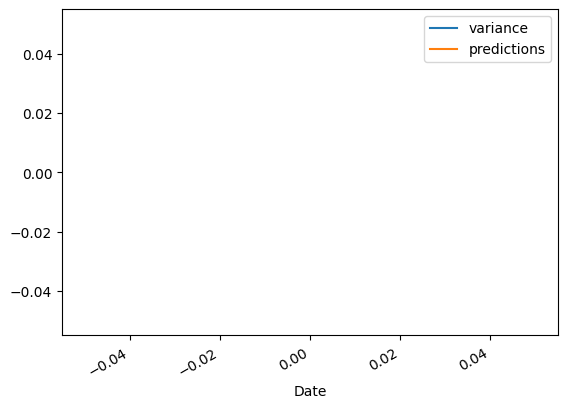

In [16]:
df_day[['variance', 'predictions']].plot()

## Calculating the prediction premium and forming a daily signal from it. 

- We are calculating the prediction premium. And then calculating its 6-month rolling standard deviation. 
- The prediction premium is the difference between the predicted value and the actual value. The 6-month rolling
- From this we are creating our daily signal.

In [17]:
df_day['prediction_premium'] = (df_day['predictions'] - df_day['variance']) / df_day['variance']
df_day['prediction std'] = df_day['prediction_premium'].rolling(180).std()
df_day

,Open,High,Low,Close,Adj Close,Volume,Unnamed: 7,log return,variance,predictions,prediction_premium,prediction std
Date,,,,,,,,,,,,


<Axes: xlabel='Date'>

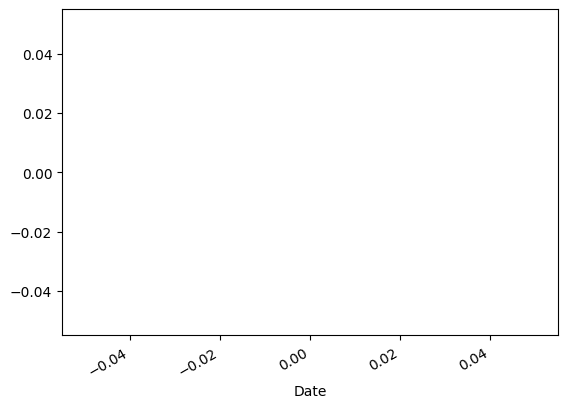

In [18]:
df_day['prediction_premium'].plot()

<Axes: xlabel='Date'>

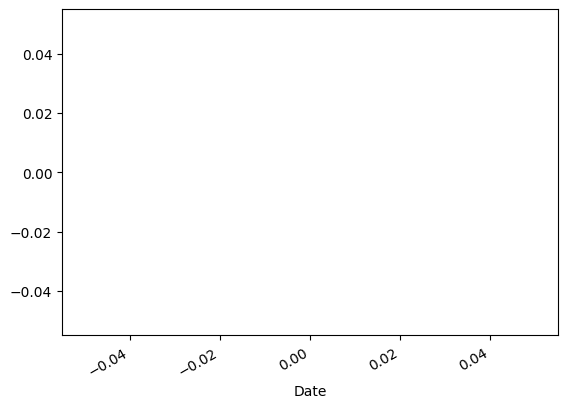

In [19]:
df_day['prediction std'].plot()

In [20]:
#Now calculating the daily signal. 
df_day['daily signal'] = df_day.apply(lambda x: 1 if (x['prediction_premium'] > x['prediction std'] * 1.5)
                                      else (-1 if (x['prediction_premium'] < x['prediction std'] * -1.5) else np.nan), 
                                      axis=1)
df_day

,Open,High,Low,Close,Adj Close,Volume,Unnamed: 7,log return,variance,predictions,prediction_premium,prediction std,daily signal
Date,,,,,,,,,,,,,


[]

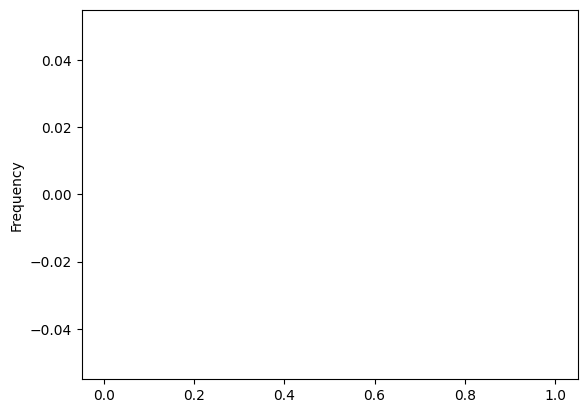

In [21]:
df_day['daily signal'].plot(kind='hist')
plt.plot()

In [22]:
df_day['daily signal'] = df_day['daily signal'].shift()

In [23]:
df_day

,Open,High,Low,Close,Adj Close,Volume,Unnamed: 7,log return,variance,predictions,prediction_premium,prediction std,daily signal
Date,,,,,,,,,,,,,


## Merging with intraday data and calculating intraday indicators to form intraday signals. 

Calculating all intraday indicators and signals

In [24]:
df_intraday['date'] = pd.to_datetime(df_intraday.index.date)

In [25]:
df_intraday

,open,low,high,close,volume,date
datetime,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,2021-09-29
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,2021-09-29
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,2021-09-29
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,2021-09-29
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,2021-09-29
...,...,...,...,...,...,...
2023-09-20 10:40:00,6792.1025,6783.6000,6796.2500,6790.1375,41,2023-09-20
2023-09-20 10:45:00,6790.5575,6779.1000,6795.7500,6781.9175,42,2023-09-20
2023-09-20 10:50:00,6781.5475,6779.3750,6790.2500,6783.9050,44,2023-09-20


In [26]:
final_df = df_intraday.reset_index()\
.merge(df_day[['daily signal']].reset_index(), 
       left_on='date', 
       right_on='Date')\
.set_index('datetime')

final_df

,open,low,high,close,volume,date,Date,daily signal
datetime,,,,,,,,


In [27]:
final_df = final_df.drop(['date', 'Date'], axis=1)
final_df

,open,low,high,close,volume,daily signal
datetime,,,,,,


In [28]:
final_df['rsi'] = pandas_ta.rsi(close=final_df['close'], 
                                length=20)
final_df

,open,low,high,close,volume,daily signal,rsi
datetime,,,,,,,


In [29]:
#Lower and upper bolinger bands. 
final_df['lband'] = pandas_ta.bbands(close=final_df['close'], 
                                length=20).iloc[:,0]

final_df['uband'] = pandas_ta.bbands(close=final_df['close'], 
                                length=20).iloc[:,2]
final_df

AttributeError: 'NoneType' object has no attribute 'iloc'

In [68]:
#Intraday signal
final_df['signal_intraday'] = final_df.apply(lambda x: 1 if (x['rsi']>70)&
                                                            (x['close']>x['uband'])
                                             else (-1 if (x['rsi']<30)&
                                                         (x['close']<x['lband']) else np.nan),
                                             axis=1)
final_df

,open,low,high,close,volume,daily signal,rsi,lband,uband,signal_intraday
datetime,,,,,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN,NaN,NaN,NaN,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN,NaN,NaN,NaN,NaN
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN,NaN,NaN,NaN,NaN
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN,NaN,NaN,NaN,NaN
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-09-18 23:35:00,6708.0025,6705.5175,6712.0000,6708.8675,11,NaN,62.861699,6677.365065,6715.855435,NaN
2023-09-18 23:40:00,6708.8650,6707.1800,6714.2500,6709.3350,22,NaN,63.165869,6679.544207,6716.559793,NaN
2023-09-18 23:45:00,6709.9250,6704.3600,6713.5000,6708.2750,25,NaN,61.954798,6682.379916,6716.534084,NaN


## Determining the position of entry and holding time. 

We're going to have a short position whenever the daily and intraday signal is 1, else taking the long position.  

In [87]:
final_df['return_sign'] = final_df.apply(lambda x: -1 if (x['daily signal']==1)&(x['signal_intraday']==1)
                                        else (1 if (x['daily signal']==-1)&(x['signal_intraday']==-1) else np.nan),
                                        axis=1)
#1 for long position and -1 for short
final_df

,open,low,high,close,volume,daily signal,rsi,lband,uband,signal_intraday,return_sign,return,forward_return,strategy_return
datetime,,,,,,,,,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000018,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN,NaN,NaN,NaN,NaN,NaN,0.000018,0.001270,NaN
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN,NaN,NaN,NaN,NaN,NaN,0.001270,0.005605,NaN
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN,NaN,NaN,NaN,NaN,NaN,0.005605,-0.000146,NaN
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN,NaN,NaN,NaN,NaN,NaN,-0.000146,-0.000813,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-18 23:35:00,6708.0025,6705.5175,6712.0000,6708.8675,11,NaN,62.861699,6677.365065,6715.855435,NaN,NaN,0.000128,0.000070,NaN
2023-09-18 23:40:00,6708.8650,6707.1800,6714.2500,6709.3350,22,NaN,63.165869,6679.544207,6716.559793,NaN,NaN,0.000070,-0.000158,NaN
2023-09-18 23:45:00,6709.9250,6704.3600,6713.5000,6708.2750,25,NaN,61.954798,6682.379916,6716.534084,NaN,NaN,-0.000158,-0.000368,NaN


In [88]:
#Checking out the long positions entries
final_df[final_df['return_sign']==1]

,open,low,high,close,volume,daily signal,rsi,lband,uband,signal_intraday,return_sign,return,forward_return,strategy_return
datetime,,,,,,,,,,,,,,
2021-10-20 16:25:00,16453.7750,16422.2775,16490.250,16422.2775,183,-1.0,28.612648,16446.656872,16726.321628,-1.0,1.0,-0.001979,0.001673,0.001673
2021-10-20 21:50:00,16308.4050,16237.5000,16318.675,16255.2650,340,-1.0,25.844043,16288.575674,16496.577807,-1.0,1.0,-0.003258,-0.000525,-0.000525
2021-10-20 21:55:00,16255.0425,16159.2825,16282.250,16246.7350,564,-1.0,25.220144,16263.826209,16501.461522,-1.0,1.0,-0.000525,-0.007915,-0.007915
2021-10-20 22:00:00,16246.7350,16011.7250,16295.500,16118.1400,870,-1.0,18.234580,16203.703409,16530.324822,-1.0,1.0,-0.007915,0.003807,0.003807
2021-10-26 17:40:00,15445.4500,15262.5000,15449.500,15321.7360,461,-1.0,26.912112,15399.643772,15607.113578,-1.0,1.0,-0.007801,0.000870,0.000870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-16 19:35:00,7202.1350,7175.0000,7211.000,7187.2225,250,-1.0,26.667744,7193.872562,7243.550188,-1.0,1.0,-0.001938,-0.000911,-0.000911
2023-08-16 19:40:00,7187.7850,7176.6825,7197.250,7180.6750,101,-1.0,24.700209,7186.942463,7245.637787,-1.0,1.0,-0.000911,0.000590,0.000590
2023-08-16 20:35:00,7175.0000,7129.2325,7182.750,7140.4850,376,-1.0,26.247159,7153.560625,7223.641875,-1.0,1.0,-0.004810,-0.004597,-0.004597


In [113]:
#Checking the short positions entries
final_df[final_df['return_sign'] == -1]

,open,low,high,close,volume,daily signal,rsi,lband,uband,signal_intraday,return_sign,return,forward_return,strategy_return
datetime,,,,,,,,,,,,,,


In [90]:
#Forward filling the fist entry values or point until the rest of the day
final_df['return_sign'] = final_df.groupby(pd.Grouper(freq='D'))['return_sign']\
.transform(lambda x: x.ffill())

In [91]:
final_df['return'] = final_df['close'].pct_change()

In [118]:
final_df['forward_return'] = final_df['return'].shift(-1)
final_df['strategy_return'] = final_df['forward_return'] * final_df['return_sign']
final_df

,open,low,high,close,volume,daily signal,rsi,lband,uband,signal_intraday,return_sign,return,forward_return,strategy_return
datetime,,,,,,,,,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000018,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN,NaN,NaN,NaN,NaN,NaN,0.000018,0.001270,NaN
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN,NaN,NaN,NaN,NaN,NaN,0.001270,0.005605,NaN
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN,NaN,NaN,NaN,NaN,NaN,0.005605,-0.000146,NaN
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN,NaN,NaN,NaN,NaN,NaN,-0.000146,-0.000813,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-18 23:35:00,6708.0025,6705.5175,6712.0000,6708.8675,11,NaN,62.861699,6677.365065,6715.855435,NaN,NaN,0.000128,0.000070,NaN
2023-09-18 23:40:00,6708.8650,6707.1800,6714.2500,6709.3350,22,NaN,63.165869,6679.544207,6716.559793,NaN,NaN,0.000070,-0.000158,NaN
2023-09-18 23:45:00,6709.9250,6704.3600,6713.5000,6708.2750,25,NaN,61.954798,6682.379916,6716.534084,NaN,NaN,-0.000158,-0.000368,NaN


In [119]:
df_daily_return = final_df.groupby(pd.Grouper(freq='D'))[['strategy_return']].sum()
df_daily_return

,strategy_return
datetime,
2021-09-29,0.0
2021-09-30,0.0
2021-10-01,0.0
2021-10-02,0.0
2021-10-03,0.0
...,...
2023-09-14,0.0
2023-09-15,0.0
2023-09-16,0.0


## Calculating the final strategy returns

In [120]:
import matplotlib.ticker as mtick

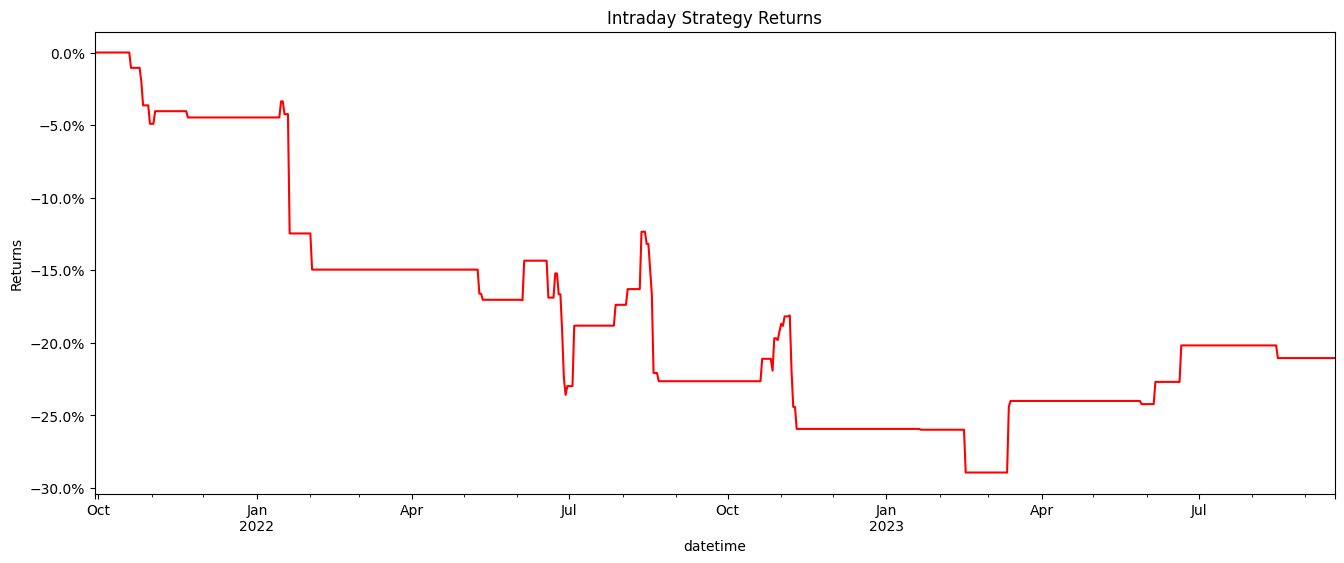

In [135]:
cumulative_strat_returns = np.exp(np.log1p(df_daily_return['strategy_return']).cumsum()).sub(1)

cumulative_strat_returns.plot(figsize=(16,6), color='red')

plt.title('Intraday Strategy Returns')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Returns')

plt.show()